# Homework 03: Learning Curves and Training Workflow

**Points:** 85

In this assignment, you will learn how to design, train, and evaluate neural networks by systematically exploring key design choices. Your focus will be on developing an effective **training workflow** — using learning curves and validation metrics to guide your decisions.

We'll use the **Forest Cover Type (Covertype) dataset,** which has ~581k tabular records with 54 cartographic/topographic features (elevation, aspect, slope, soil and wilderness indicators) used to predict one of seven tree cover types in Colorado’s Roosevelt National Forest. It’s a large, mildly imbalanced multi-class benchmark commonly used to compare classical ML and deep learning on tabular data.

We will start with a **baseline model** (two hidden layers of sizes 64 and 32), and gradually introduce and tune different hyperparameters. Each of the first five problems considers  different hyperparameter choices, and the last problem is your chance to use what you have learned to design your best model:

1. **Activation function** – Compare ReLU, sigmoid, and tanh to see which provides the best accuracy.
2. **Learning rate** – Explore a range of learning rates and identify which balances convergence speed and stability.
3. **Dropout** – Investigate how different dropout rates reduce overfitting and where they are most effective.
4. **L2 regularization** – Experiment with weight penalties to encourage simpler models and avoid memorization.
5. **Dropout + L2** – Combine both regularization techniques and study their interaction.
6. **Best model design** – Use all your insights to build and train your strongest model, with the option to try **learning rate scheduling** for further improvement.

In this homework, you will use **early stopping** to select the "best" model at the epoch of **minimum validation loss**, and you will report the **validation accuracy** of that selected model as the primary measure of performance. Test accuracy is reported for reference but is not used for model selection.

> **Note:** Throughout this homework, best always refers to the model selected by early stopping at the epoch of minimum validation loss. Do not report metrics from the final training epoch unless explicitly instructed.

By the end of this homework, you will not only understand how different hyperparameters affect training and generalization, but also gain hands-on practice in building a disciplined workflow for model development.

There are 10 graded problems, worth 8 points each, with 5 points for free if you complete the homework. 

In [1]:
# Useful imports

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter
import time
import os

from sklearn.model_selection import train_test_split, StratifiedShuffleSplit
from sklearn.preprocessing import StandardScaler
from sklearn.utils import class_weight

import tensorflow as tf
from tensorflow.keras import layers, models, regularizers
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense,Input,Dropout
from tensorflow.keras.optimizers import Adam

from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers.schedules import ExponentialDecay


from tensorflow.keras.datasets import fashion_mnist

# utility code

random_seed = 42

def format_hms(seconds):
    return time.strftime("%H:%M:%S", time.gmtime(seconds))

os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'  # Suppresses INFO and WARNING messages


In [2]:
# Utility function to plot learning curves and keep track of all results

# Call `print_results()` to see listing of all results logged so far


def plot_learning_curves(hist, title, verbose=True):
    
    val_losses = hist.history['val_loss']
    min_val_loss = min(val_losses)
    min_val_epoch = val_losses.index(min_val_loss)
    val_acc_at_min_loss = hist.history['val_accuracy'][min_val_epoch]

    epochs = range(1, len(val_losses) + 1)  # epoch numbers starting at 1

    fig, axs = plt.subplots(2, 1, figsize=(8, 8), sharex=True)

    # --- Loss Plot ---
    axs[0].plot(epochs, hist.history['loss'], label='train loss')
    axs[0].plot(epochs, hist.history['val_loss'], label='val loss')
    axs[0].scatter(min_val_epoch + 1, min_val_loss, color='red', marker='x', s=50, label='min val loss')
    axs[0].set_title(f'{title} - Categorical Cross-Entropy Loss')
    axs[0].set_ylabel('Loss')
    axs[0].legend()
    axs[0].grid(True)

    # --- Accuracy Plot ---
    axs[1].plot(epochs, hist.history['accuracy'], label='train acc')
    axs[1].plot(epochs, hist.history['val_accuracy'], label='val acc')
    axs[1].scatter(min_val_epoch + 1, val_acc_at_min_loss, color='red', marker='x', s=50, label='acc @ min val loss')
    axs[1].set_title(f'{title} - Accuracy')
    axs[1].set_xlabel('Epoch')
    axs[1].set_ylabel('Accuracy')
    axs[1].legend()
    axs[1].grid(True)
    axs[1].set_ylim(0, 1.05)

    plt.tight_layout()
    plt.show()

    if verbose:
        print(f"Final Training Loss:            {hist.history['loss'][-1]:.4f}")
        print(f"Final Training Accuracy:        {hist.history['accuracy'][-1]:.4f}")
        print(f"Final Validation Loss:          {hist.history['val_loss'][-1]:.4f}")
        print(f"Final Validation Accuracy:      {hist.history['val_accuracy'][-1]:.4f}")
        print(f"Minimum Validation Loss:        {min_val_loss:.4f} (Epoch {min_val_epoch + 1})")
        print(f"Validation Accuracy @ Min Loss: {val_acc_at_min_loss:.4f}")

    results[title] = (val_acc_at_min_loss,min_val_epoch + 1)

results = {}

**The plotting function will record the validation accuracy for each experiment, using the plot title as key. The next function will print these out (see the last cell in the notebook).**


In order to see all results, you must give a different plot title to each experiment.

In [3]:
def print_results():
    for title, (acc, ep) in sorted(results.items(), 
                                   key=lambda kv: kv[1][0],   # kv[1] is (acc, epoch); [0] is acc
                                   reverse=True
                                  ):
        print(f"{title:<40}\t{acc:.4f}")

### Wrapper to train, display results, and run test set

We assume multi-class classification, and allow setting various parameters for training. 

In [4]:
# Uses globals X_train,y_train,X_val,y_val

def train_and_test(model, 
                   epochs        = 500,                   # Just needs to be bigger than early stop point
                   lr_schedule   = 0.001,                 # Adam default / 10 seems to work well for this dataset
                   optimizer     = "Adam",
                   title         = "Learning Curves",
                   batch_size    = 64,                     # experiments confirmed this was optimal with other parameters at default
                   use_early_stopping = True,
                   patience      = 10,                                       
                   min_delta     = 0.0001,                 
                   callbacks     = [],                     # for extra callbacks other than early stopping
                   verbose       = 0,
                   return_history = False
                  ):

    print(f"\n{title}\n")


    if optimizer == "Adam":
        opt = Adam(learning_rate=lr_schedule) 
    else:
        opt = optimizer
    
    #Compiling the model
    model.compile(optimizer=opt, 
                  loss="sparse_categorical_crossentropy", 
                  metrics=["accuracy"]
                 )

    early_stop = EarlyStopping(
        monitor='val_loss',
        patience=patience,
        min_delta=min_delta,
        restore_best_weights=True,               # this will mean that the model which produced the smallest validation loss will be returned
        verbose=verbose
    )
    

    if use_early_stopping:
        cbs=[early_stop] + callbacks
    else:
        cbs=callbacks

    # start timer
    start = time.time()
    
    # Fit the model with early stopping
    history = model.fit(X_train, y_train,
                        epochs=epochs,
                        batch_size=batch_size,
                        validation_data=(X_val, y_val),       # must use stratified validation set
                        callbacks=cbs,
                        verbose=verbose
                       )

    if use_early_stopping:
        best_epoch = early_stop.best_epoch
        best_acc   = history.history['val_accuracy'][best_epoch]
    else:
        best_epoch = np.argmax(history.history['val_accuracy'])
        best_acc   = history.history['val_accuracy'][best_epoch]
    
    # Plot training history
    plot_learning_curves(history, title=title)

    # Evaluate on test data
    test_loss, test_accuracy = model.evaluate(X_test, y_test, verbose=0)
    
    print(f"\nTest Loss: {test_loss:.4f}")
    print(f"Test Accuracy: {test_accuracy:.4f}")

    print(f"\nValidation-Test Gap (accuracy): {abs(best_acc - test_accuracy):.6f}")
    
    # Record end time and print execution time
    end = time.time()
    print(f"\nExecution Time: " + format_hms(end-start))

    if return_history:
        return history

### Load the dataset and extract a stratified subset

This data set is rather large (581,012 samples) and unbalanced, but for the purposes of this homework, we use a much smaller set, and select samples so that it is balanced. 

In [5]:
# complete cell: load, balance, split into X_train/y_train/x_val/y_val/X_test/y_test, and standardize
from collections import Counter
from sklearn.datasets import fetch_covtype
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import numpy as np

# 1) load
x, y = fetch_covtype(return_X_y=True)  # y in {1..7}
print("full dataset shape:", x.shape)

# 2) build a perfectly balanced subset across 7 classes (no replacement)
classes, counts = np.unique(y, return_counts=True)
# min_count = counts.min()  # size of rarest class                         # You can modify this parameter to increase the size of the dataset, but above
min_count = 1000                                                           # counts.min() you'll produce an unbalanced set. 


rng = np.random.default_rng(42)

idx_list = []
for c in classes:
    c_idx = np.where(y == c)[0]
    chosen = rng.choice(c_idx, size=min_count, replace=False)
    idx_list.append(chosen)

idx_bal = np.concatenate(idx_list)
rng.shuffle(idx_bal)

X_sub = x[idx_bal]
y_sub = y[idx_bal] - 1  # relabel to {0..6} for keras
print("balanced subset shape:", X_sub.shape, "class counts:", dict(Counter(y_sub)))

# 3) stratified 60/20/20 split (train/val/test)
test_size = 0.20
val_size = 0.20  # of the whole dataset

X_trainval, X_test, y_trainval, y_test = train_test_split(
    X_sub, y_sub, test_size=test_size, random_state=random_seed, stratify=y_sub
)
val_size_rel = val_size / (1.0 - test_size)  # e.g., 0.20 / 0.80 = 0.25

X_train, X_val, y_train, y_val = train_test_split(
    X_trainval, y_trainval, test_size=val_size_rel, random_state=random_seed, stratify=y_trainval
)

# 4) standardize using train-only stats (float32 for tensorflow friendliness)
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train).astype(np.float32)
X_val   = scaler.transform(X_val).astype(np.float32)
X_test  = scaler.transform(X_test).astype(np.float32)

# 5) quick sanity checks
def show_counts(name, y_arr):
    c = Counter(y_arr)
    total = sum(c.values())
    print(f"{name}: total={total}, per-class={dict(c)}")

print("shapes:", "X_train", X_train.shape, "X_val", X_val.shape, "X_test", X_test.shape)
show_counts("train", y_train)
show_counts("val  ", y_val)
show_counts("test ", y_test)

# you now have: X_train, y_train, X_val, y_val, X_test, y_test

# Looks like integer encoded multi-class, let's check and define the global n_classes

labels = np.unique(y_train)

n_classes = len(labels)

print("class labels:",labels)


full dataset shape: (581012, 54)
balanced subset shape: (7000, 54) class counts: {np.int32(2): 1000, np.int32(0): 1000, np.int32(4): 1000, np.int32(5): 1000, np.int32(1): 1000, np.int32(3): 1000, np.int32(6): 1000}
shapes: X_train (4200, 54) X_val (1400, 54) X_test (1400, 54)
train: total=4200, per-class={np.int32(2): 600, np.int32(1): 600, np.int32(0): 600, np.int32(3): 600, np.int32(5): 600, np.int32(4): 600, np.int32(6): 600}
val  : total=1400, per-class={np.int32(1): 200, np.int32(6): 200, np.int32(5): 200, np.int32(4): 200, np.int32(3): 200, np.int32(2): 200, np.int32(0): 200}
test : total=1400, per-class={np.int32(0): 200, np.int32(6): 200, np.int32(2): 200, np.int32(3): 200, np.int32(4): 200, np.int32(5): 200, np.int32(1): 200}
class labels: [0 1 2 3 4 5 6]


## Prelude: Defining a model builder

In order to facilitate our experimentation, we'll write a function which builds models according to specifications:

- How many layers
- How wide each layer is
- How much dropout in each layer
- How much L2 Regularization in each layer

This is a fairly standard practice in ML, since the structure of simple models is fairly predictable and can be specified by a few hyperparameters. 

In [6]:
# This function will build a multi-class classifier with dropout and L2 regularization.
# You must specify the number of input features, the number of classes, and a list of layer hyperparameters
# in the form  [ ...., (width, activation function, L2 lambda, dropout rate), .... ]

# Note that when adding dropout, this appears as a separate layer, but it has no parameters to be trained. 

def build_model(n_inputs,layer_list,n_classes):
    layers = [ Input(shape=(n_inputs,)) ]
    for (width,act,l2_lambda,dropout_rate) in layer_list:
        layers.append( Dense(width, activation=act, kernel_regularizer=regularizers.l2(l2_lambda)) )
        if dropout_rate > 0:
            layers.append( Dropout(dropout_rate) )
    layers.append( Dense(n_classes, activation='softmax') )
    return models.Sequential( layers )


**Example: To build the following model:**

In [7]:
model = models.Sequential(
   [
    Input(shape=(X_train.shape[1],)),                              
    Dense(64, activation='relu', kernel_regularizer=regularizers.l2(0.0)),              # 0.0 means no regularization applied; no dropout, so no Dropout layer necessary
    Dense(32, activation='relu', kernel_regularizer=regularizers.l2(0.001)),
    Dropout(0.3),
    Dense(n_classes, activation='softmax')
   ]
)

model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 64)             │         3,520 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 7)              │           231 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 5,831 (22.78 KB)

 Trainable params: 5,831 (22.78 KB)

 Non-trainable params: 0 (0.00 B)

**We call `build_model` as shown here:**

In [8]:
build_model(X_train.shape[1], [ (64,'relu',0.0,0.0), (32,'relu',0.001,0.3)], n_classes).summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_3 (Dense)                 │ (None, 64)             │         3,520 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 7)              │           231 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 5,831 (22.78 KB)

 Trainable params: 5,831 (22.78 KB)

 Non-trainable params: 0 (0.00 B)

-------------------



### Baseline Model Architecture

**Problems 1–5 will use the following baseline model structure,** implemented with the provided `build_model` function and trained using `train_and_test`:

```
input → 64 → 32 → output
```

* Two hidden layers of widths 64 and 32.
* Activation function, dropout rate, and L2 regularization term (λ) will vary as specified in each problem.
* **Early stopping** is always applied to select the model at the epoch of **minimum validation loss**.
* We will report the **validation accuracy** of the selected model as the primary metric.


### Problem One: Which Activation Function?

In this problem, you will train the **baseline neural network** and investigate which activation function produces the best performance. The model you create will be the one saved by **early stopping** — that is, the epoch where validation loss is minimized.

**Steps to follow:**

* Use the provided functions `train_and_test` and `build_model` to create a model named **`model_baseline`**.
* Train and evaluate this model using each of the following activation functions in the hidden layers:

  * `relu`
  * `sigmoid`
  * `tanh`
* Identify which activation function produces the **best validation accuracy** at the epoch of **minimum validation loss**.
* Answer the graded questions.



Activation: relu



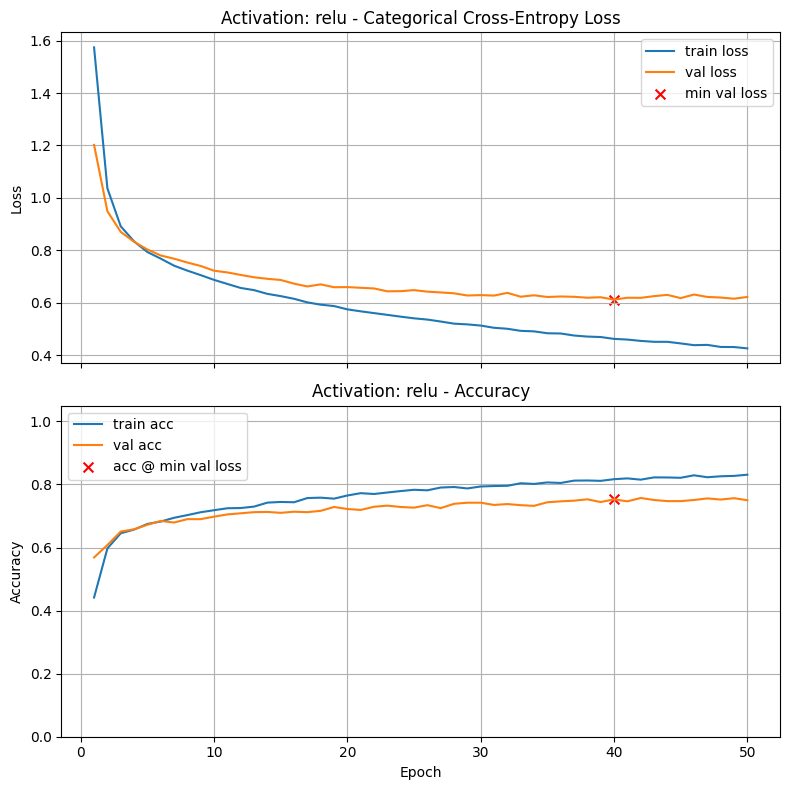

Final Training Loss:            0.4255
Final Training Accuracy:        0.8310
Final Validation Loss:          0.6218
Final Validation Accuracy:      0.7500
Minimum Validation Loss:        0.6115 (Epoch 40)
Validation Accuracy @ Min Loss: 0.7529

Test Loss: 0.6064
Test Accuracy: 0.7450

Validation-Test Gap (accuracy): 0.007857

Execution Time: 00:00:07

Activation: sigmoid



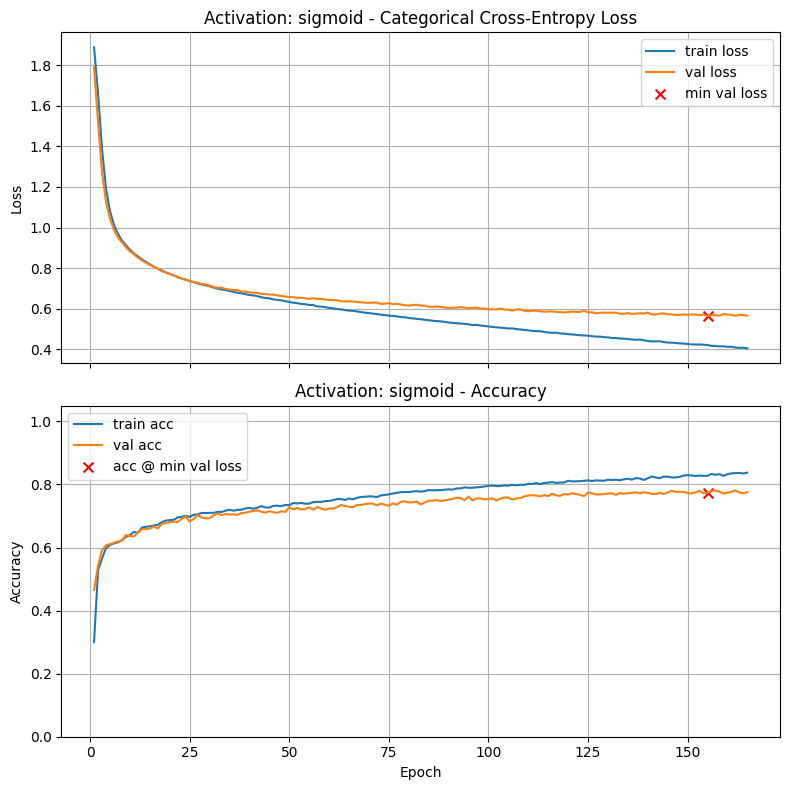

Final Training Loss:            0.4040
Final Training Accuracy:        0.8376
Final Validation Loss:          0.5653
Final Validation Accuracy:      0.7757
Minimum Validation Loss:        0.5627 (Epoch 155)
Validation Accuracy @ Min Loss: 0.7736

Test Loss: 0.5667
Test Accuracy: 0.7607

Validation-Test Gap (accuracy): 0.012857

Execution Time: 00:00:20

Activation: tanh



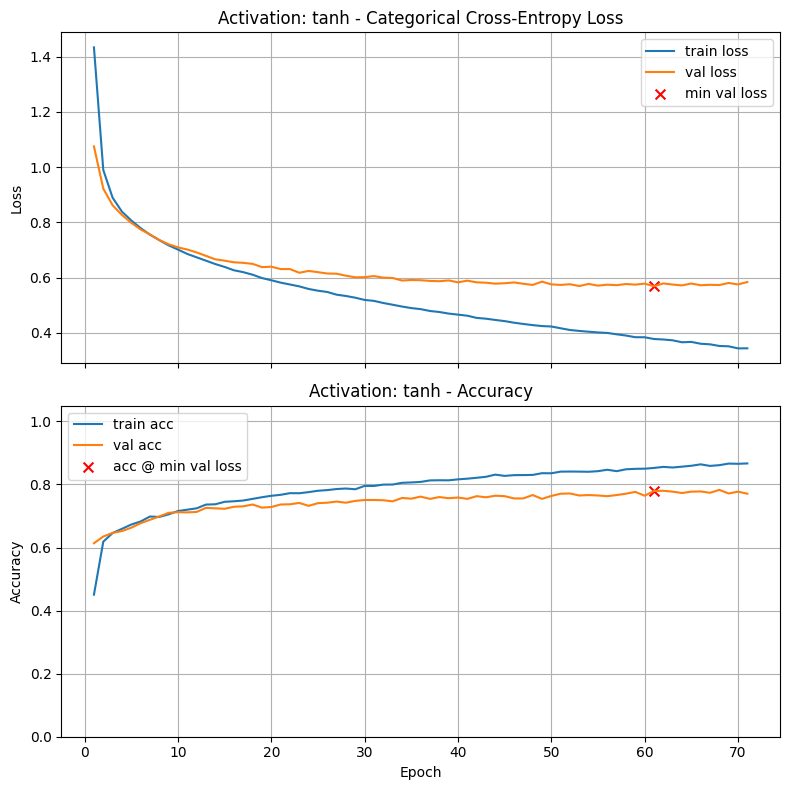

Final Training Loss:            0.3440
Final Training Accuracy:        0.8667
Final Validation Loss:          0.5841
Final Validation Accuracy:      0.7707
Minimum Validation Loss:        0.5688 (Epoch 61)
Validation Accuracy @ Min Loss: 0.7793

Test Loss: 0.5637
Test Accuracy: 0.7671

Validation-Test Gap (accuracy): 0.012143

Execution Time: 00:00:09
Activation: tanh                        	0.7793
Activation: sigmoid                     	0.7736
Activation: relu                        	0.7529


In [9]:
# Your code here. Add as many cells as you need. 

activations = ['relu', 'sigmoid', 'tanh']

for act in activations:
    model_baseline = build_model(X_train.shape[1], [(64, act, 0.0, 0.0), (32, act, 0.0, 0.0)], n_classes)
    
    train_and_test(model_baseline, title=f"Activation: {act}", verbose=0)

print_results()


### Graded Questions

In [10]:
# Set a1a to the activation function which provided the best validation accuracy at the epoch of minimum validation loss

a1a = 2             # Replace with integer 0 (relu), 1 (sigmoid), or 2 (tanh)

In [11]:
# Graded Answer
# DO NOT change this cell in any way          

print(f'a1a = {a1a}') 


a1a = 2


In [36]:
# Set a1b to the validation accuracy found by this best activation function

a1b = 0.7793             # Replace 0.0 with your answer

In [37]:
# Graded Answer
# DO NOT change this cell in any way          

print(f'a1b = {a1b:.4f}') 

a1b = 0.7793


### Problem Two: Finding the Right Learning Rate

In this problem, you will continue working with the **baseline model** and determine which learning rate produces the best performance. As before, the model you evaluate should be the one saved by **early stopping** — the epoch where validation loss is minimized.

**Steps to follow:**

* Build and train the **baseline model** using the **activation function identified in Problem One**.

* Train and evaluate this model using each of the following learning rates:

  ```
      [1e-3, 5e-4, 1e-4, 5e-5, 1e-5]
  ```

* Identify which learning rate produces the **best validation accuracy** at the epoch of **minimum validation loss**, within a maximum of **500 epochs**.

* Answer the graded questions.


**Note: Smaller learning rates will generally take more epochs to reach the optimal point, so some of these will not engage early stopping, but run the full 500 epochs.**



Learning Rates: 0.001



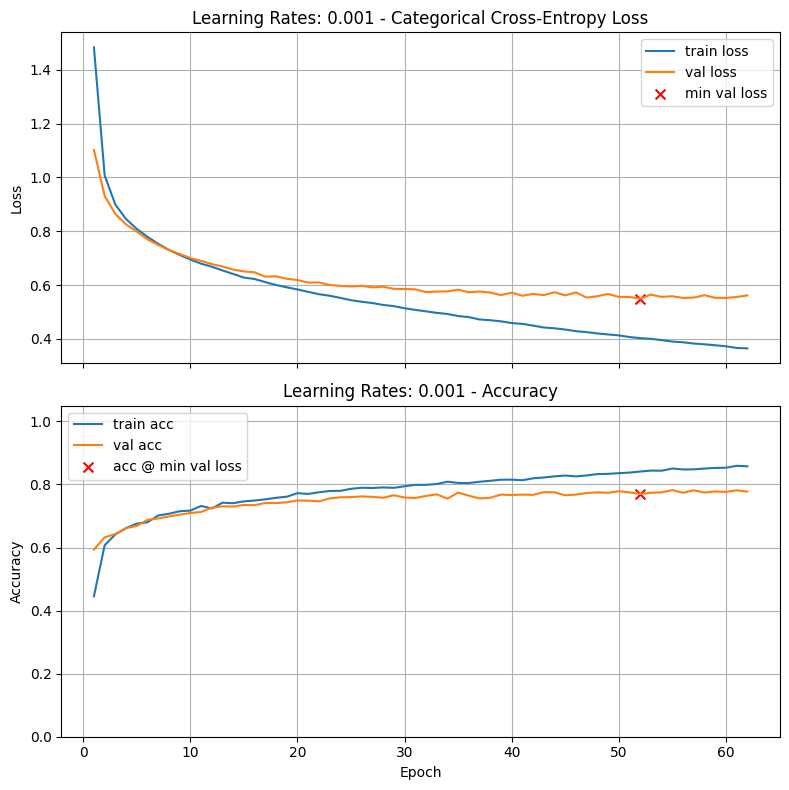

Final Training Loss:            0.3645
Final Training Accuracy:        0.8576
Final Validation Loss:          0.5613
Final Validation Accuracy:      0.7771
Minimum Validation Loss:        0.5490 (Epoch 52)
Validation Accuracy @ Min Loss: 0.7700

Test Loss: 0.5794
Test Accuracy: 0.7736

Validation-Test Gap (accuracy): 0.003571

Execution Time: 00:00:07

Learning Rates: 0.0005



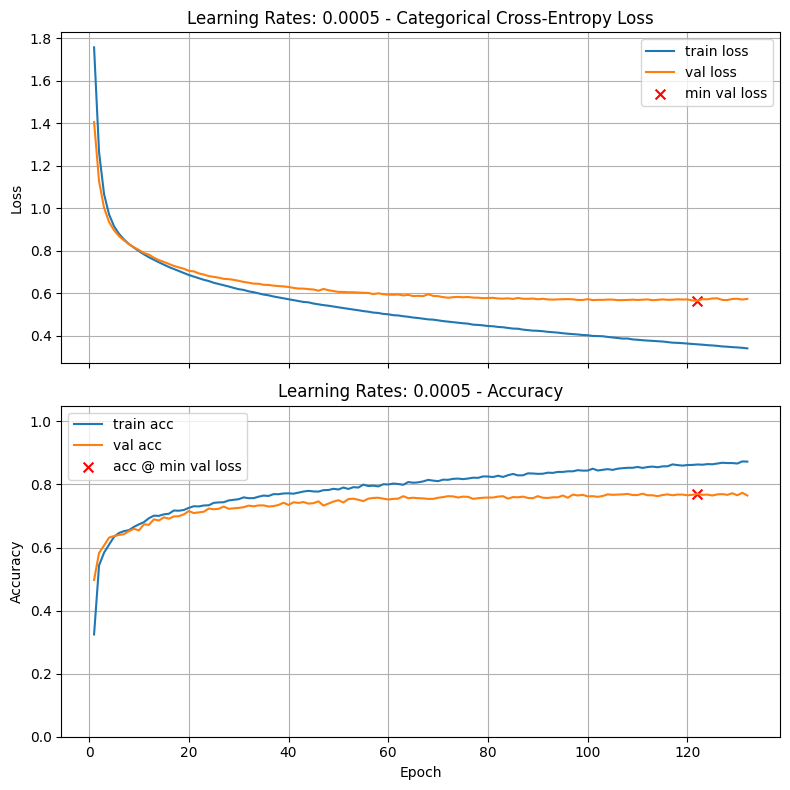

Final Training Loss:            0.3400
Final Training Accuracy:        0.8724
Final Validation Loss:          0.5731
Final Validation Accuracy:      0.7650
Minimum Validation Loss:        0.5642 (Epoch 122)
Validation Accuracy @ Min Loss: 0.7700

Test Loss: 0.5594
Test Accuracy: 0.7757

Validation-Test Gap (accuracy): 0.005714

Execution Time: 00:00:15

Learning Rates: 0.0001



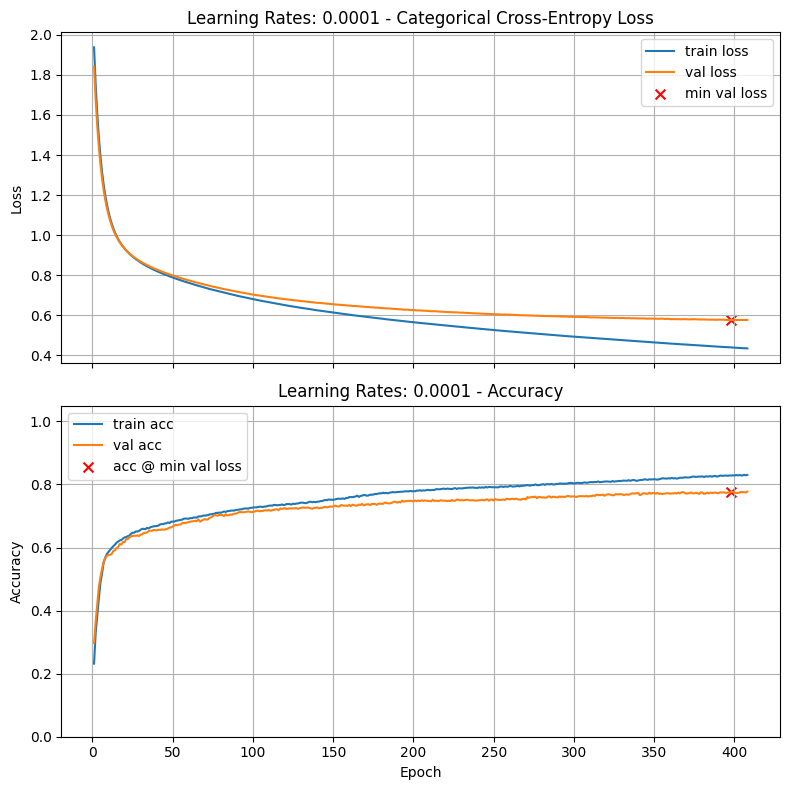

Final Training Loss:            0.4344
Final Training Accuracy:        0.8302
Final Validation Loss:          0.5764
Final Validation Accuracy:      0.7771
Minimum Validation Loss:        0.5758 (Epoch 398)
Validation Accuracy @ Min Loss: 0.7764

Test Loss: 0.5785
Test Accuracy: 0.7550

Validation-Test Gap (accuracy): 0.021429

Execution Time: 00:00:46

Learning Rates: 5e-05



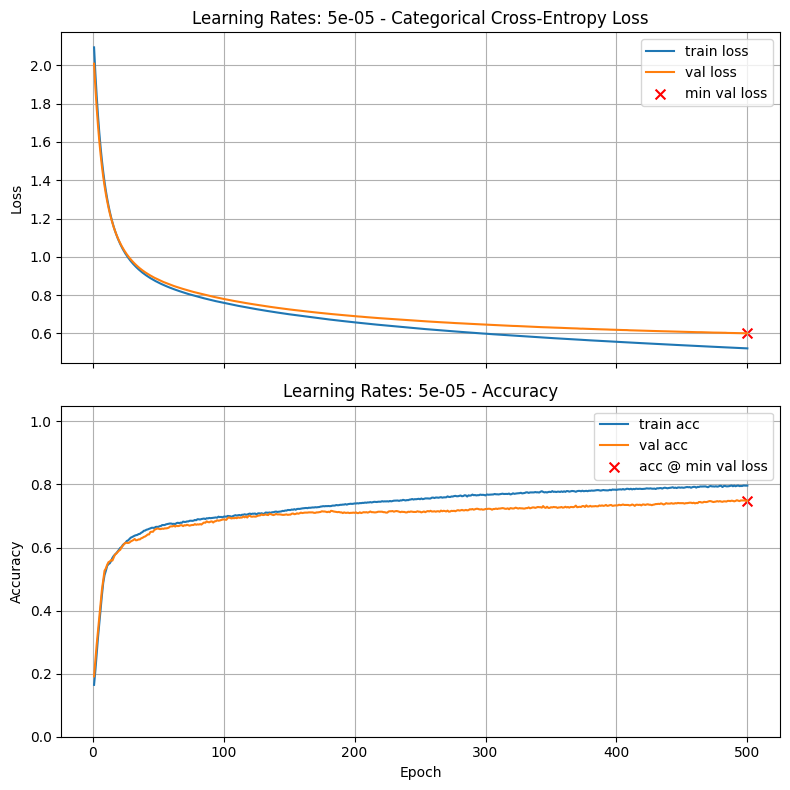

Final Training Loss:            0.5213
Final Training Accuracy:        0.7964
Final Validation Loss:          0.6000
Final Validation Accuracy:      0.7486
Minimum Validation Loss:        0.6000 (Epoch 500)
Validation Accuracy @ Min Loss: 0.7486

Test Loss: 0.6234
Test Accuracy: 0.7357

Validation-Test Gap (accuracy): 0.012857

Execution Time: 00:00:58

Learning Rates: 1e-05



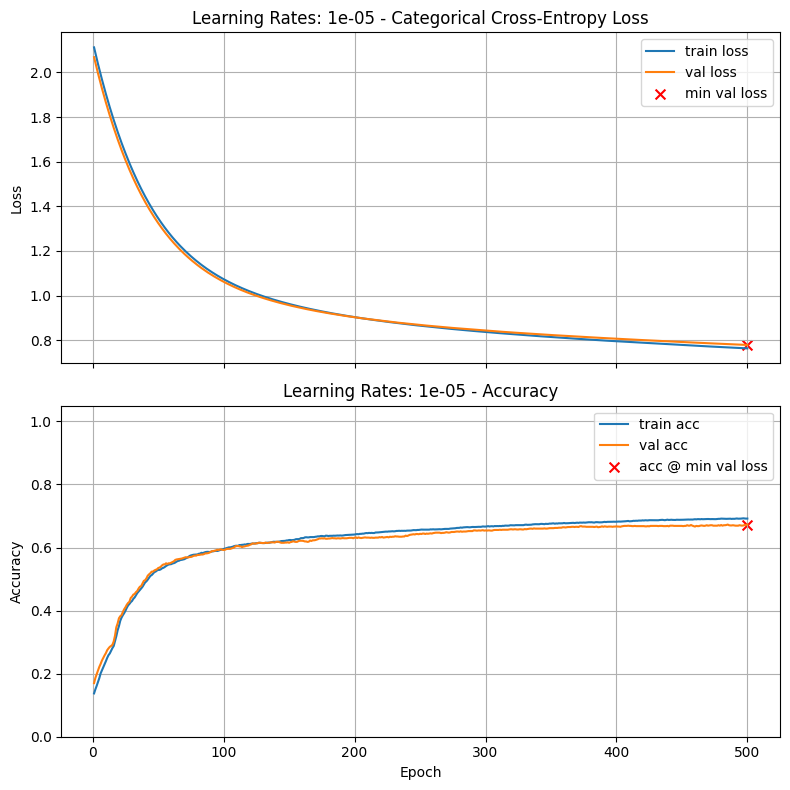

Final Training Loss:            0.7636
Final Training Accuracy:        0.6919
Final Validation Loss:          0.7790
Final Validation Accuracy:      0.6729
Minimum Validation Loss:        0.7790 (Epoch 500)
Validation Accuracy @ Min Loss: 0.6729

Test Loss: 0.7939
Test Accuracy: 0.6907

Validation-Test Gap (accuracy): 0.017857

Execution Time: 00:00:58
Learning Rates: 0.0001                  	0.7764
Learning Rates: 0.001                   	0.7700
Learning Rates: 0.0005                  	0.7700
Learning Rates: 5e-05                   	0.7486
Learning Rates: 1e-05                   	0.6729


In [39]:
# Your code here. Add as many cells as you need. 

results = {}
best_act = 'tanh'

l_rates = [1e-3, 5e-4, 1e-4, 5e-5, 1e-5]
for lr in l_rates:
    model_baseline = build_model(X_train.shape[1], [(64, best_act, 0.0, 0.0), (32, best_act, 0.0, 0.0)], n_classes)
    train_and_test(model_baseline, title=f"Learning Rates: {lr}", epochs = 500, lr_schedule=lr, verbose=0)

print_results()

#### Graded Questions

In [40]:
# Set a2a to the learning rate which provided the best validation accuracy at the epoch of minimum validation loss

a2a = 1e-4           # Replace 0.0 with your answer

In [41]:
# Graded Answer
# DO NOT change this cell in any way          

print(f'a2a = {a2a:.6f}') 

a2a = 0.000100


In [42]:
# Set a2b to the validation accuracy found by this best learning rate

a2b = 0.7764             # Replace 0.0 with your answer

In [43]:
# Graded Answer
# DO NOT change this cell in any way          

print(f'a2b = {a2b:.4f}') 

a2b = 0.7764


### Problem Three: Dropout

In this problem, you will explore how **dropout** can help prevent overfitting in neural networks. There are no absolute rules, but some useful heuristics are:

* Dropout typically works best in **later dense layers** (e.g., the second hidden layer of width 32) in the range **0.3–0.5**.
* If applied to **earlier layers** (e.g., the first hidden layer), dropout should be smaller, typically **0.0–0.2** (where 0.0 means no dropout).

**Steps to follow:**

* Build and train the **baseline model** using the **activation function from Problem One** and the **learning rate from Problem Two**.
* Investigate dropout in the ranges suggested, using increments of **0.1**.
* Identify which dropout configuration produces the **best validation accuracy** at the epoch of **minimum validation loss**.
* Answer the graded questions.



Dropout: 64=0.0, 32=0.0



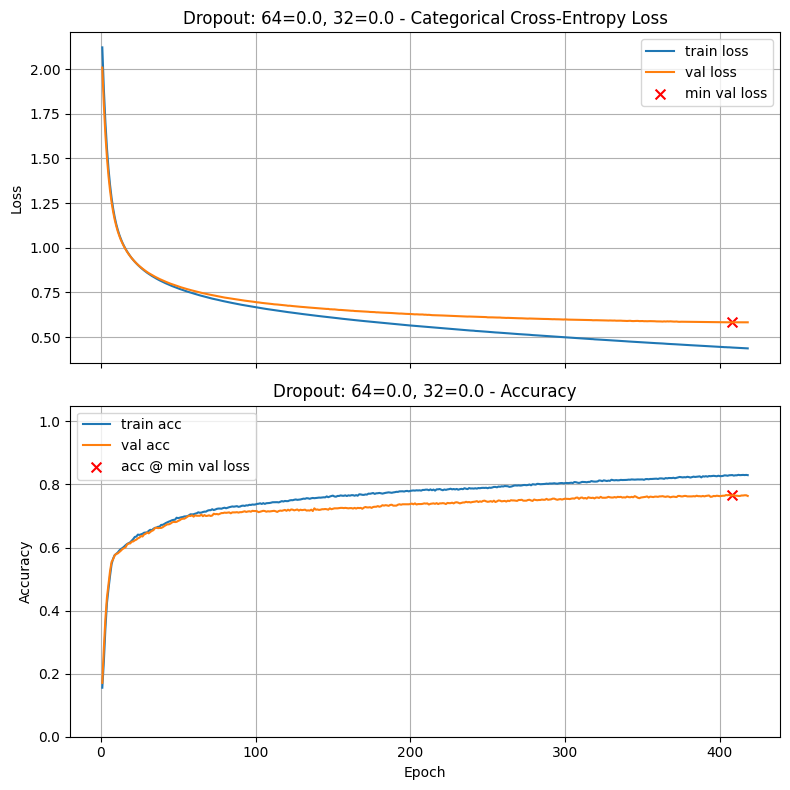

Final Training Loss:            0.4363
Final Training Accuracy:        0.8295
Final Validation Loss:          0.5822
Final Validation Accuracy:      0.7636
Minimum Validation Loss:        0.5817 (Epoch 408)
Validation Accuracy @ Min Loss: 0.7657

Test Loss: 0.5918
Test Accuracy: 0.7486

Validation-Test Gap (accuracy): 0.017143

Execution Time: 00:00:57

Dropout: 64=0.0, 32=0.1



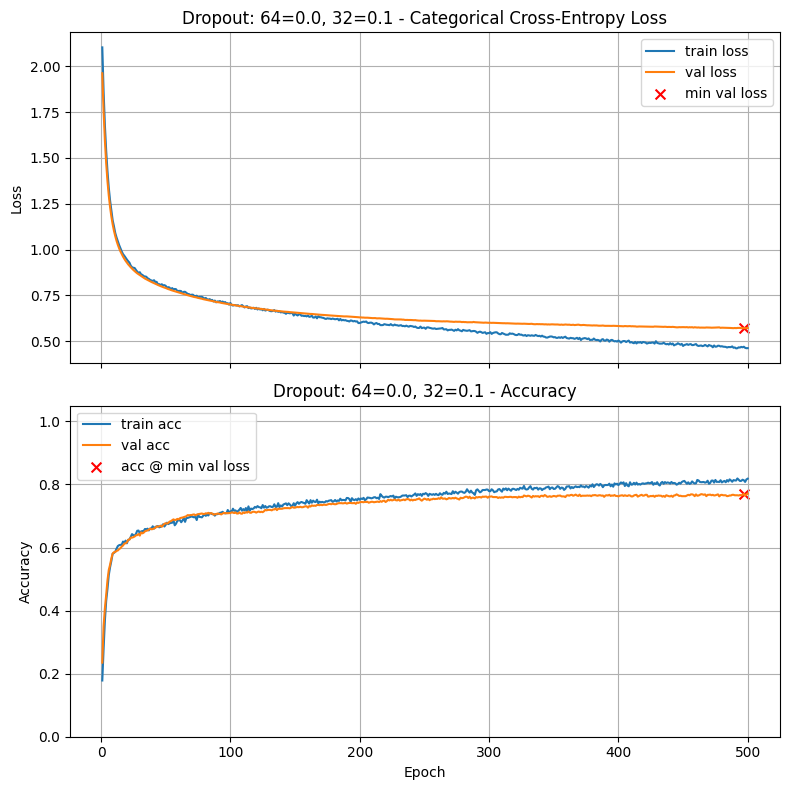

Final Training Loss:            0.4615
Final Training Accuracy:        0.8183
Final Validation Loss:          0.5710
Final Validation Accuracy:      0.7707
Minimum Validation Loss:        0.5700 (Epoch 497)
Validation Accuracy @ Min Loss: 0.7700

Test Loss: 0.5910
Test Accuracy: 0.7564

Validation-Test Gap (accuracy): 0.013571

Execution Time: 00:01:04

Dropout: 64=0.0, 32=0.2



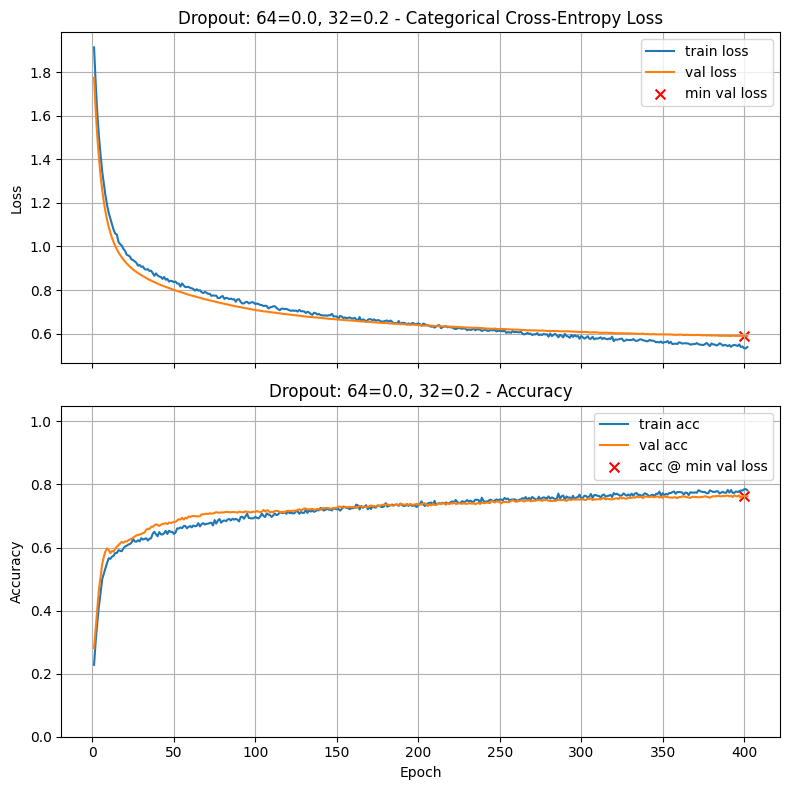

Final Training Loss:            0.5381
Final Training Accuracy:        0.7814
Final Validation Loss:          0.5888
Final Validation Accuracy:      0.7629
Minimum Validation Loss:        0.5882 (Epoch 400)
Validation Accuracy @ Min Loss: 0.7629

Test Loss: 0.6146
Test Accuracy: 0.7479

Validation-Test Gap (accuracy): 0.016429

Execution Time: 00:00:52

Dropout: 64=0.0, 32=0.3



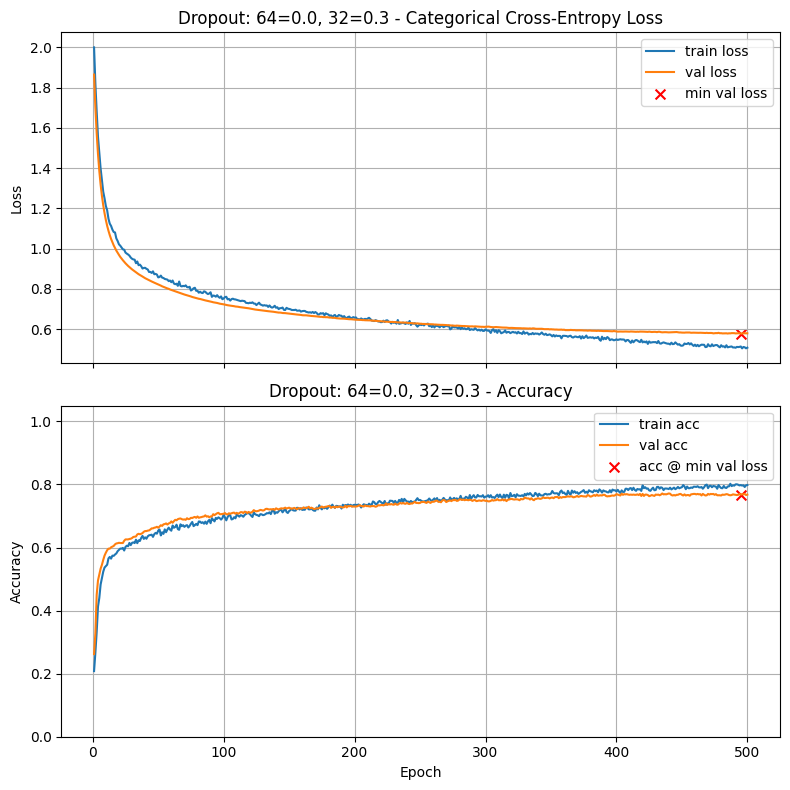

Final Training Loss:            0.5088
Final Training Accuracy:        0.7981
Final Validation Loss:          0.5801
Final Validation Accuracy:      0.7679
Minimum Validation Loss:        0.5788 (Epoch 495)
Validation Accuracy @ Min Loss: 0.7679

Test Loss: 0.5875
Test Accuracy: 0.7543

Validation-Test Gap (accuracy): 0.013571

Execution Time: 00:01:03

Dropout: 64=0.0, 32=0.4



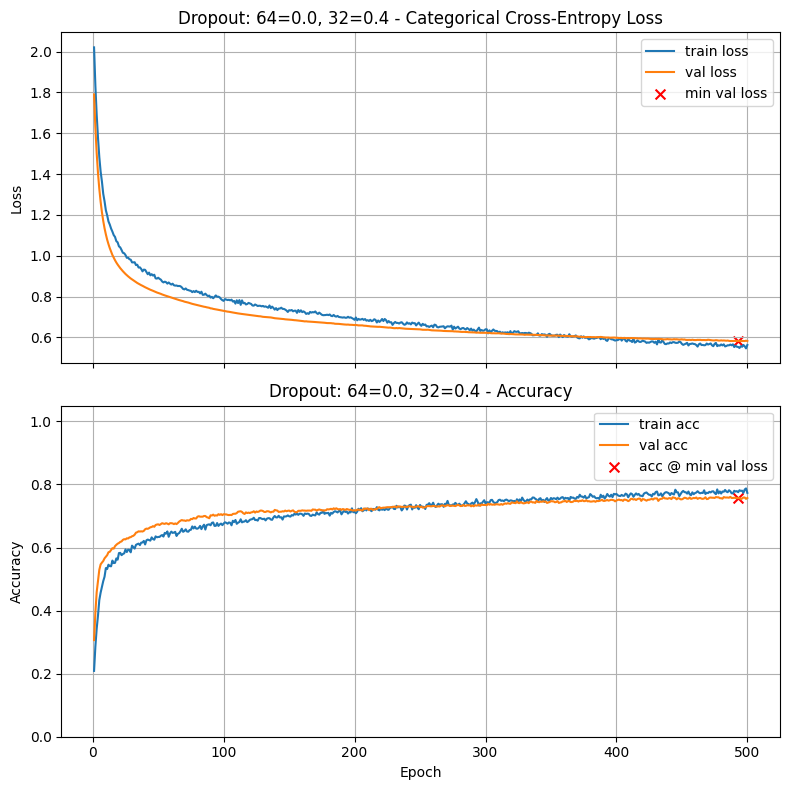

Final Training Loss:            0.5625
Final Training Accuracy:        0.7733
Final Validation Loss:          0.5820
Final Validation Accuracy:      0.7571
Minimum Validation Loss:        0.5819 (Epoch 493)
Validation Accuracy @ Min Loss: 0.7564

Test Loss: 0.6081
Test Accuracy: 0.7521

Validation-Test Gap (accuracy): 0.004286

Execution Time: 00:01:02

Dropout: 64=0.0, 32=0.5



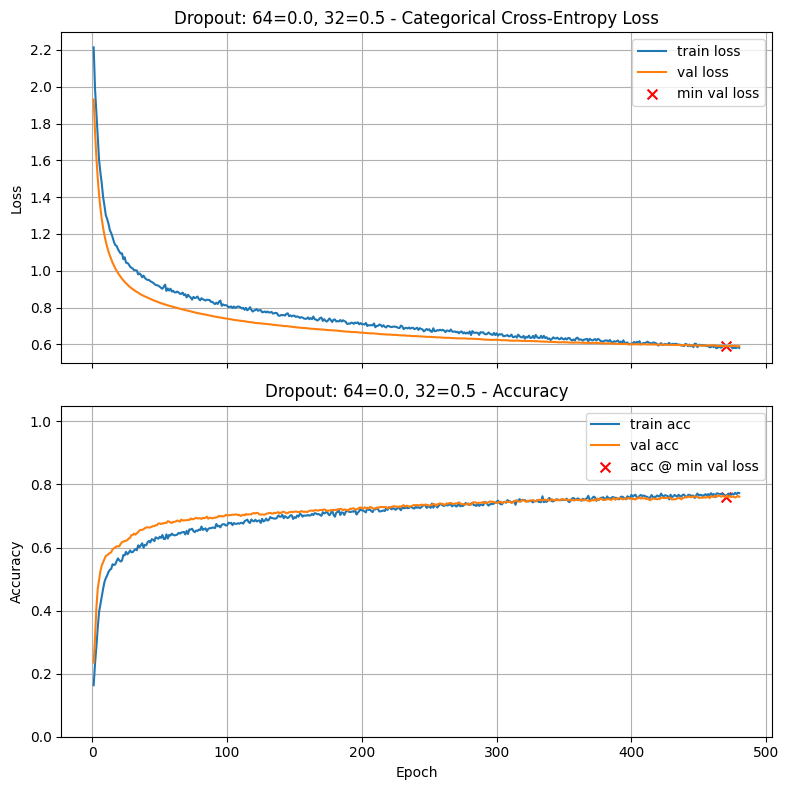

Final Training Loss:            0.5809
Final Training Accuracy:        0.7726
Final Validation Loss:          0.5907
Final Validation Accuracy:      0.7607
Minimum Validation Loss:        0.5900 (Epoch 470)
Validation Accuracy @ Min Loss: 0.7600

Test Loss: 0.6234
Test Accuracy: 0.7429

Validation-Test Gap (accuracy): 0.017143

Execution Time: 00:01:00

Dropout: 64=0.1, 32=0.0



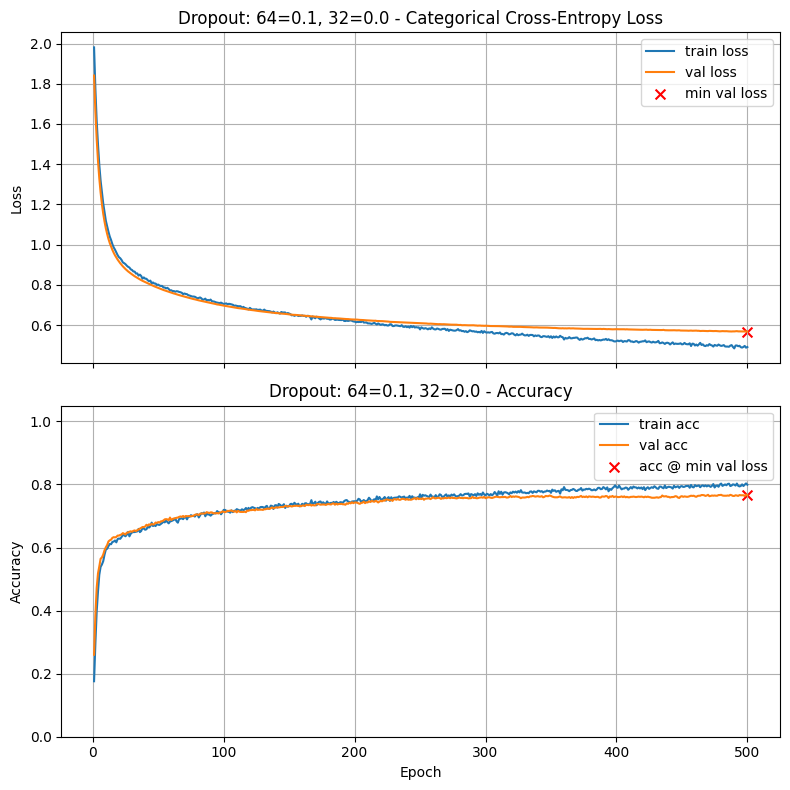

Final Training Loss:            0.4911
Final Training Accuracy:        0.7990
Final Validation Loss:          0.5681
Final Validation Accuracy:      0.7657
Minimum Validation Loss:        0.5681 (Epoch 500)
Validation Accuracy @ Min Loss: 0.7657

Test Loss: 0.5823
Test Accuracy: 0.7571

Validation-Test Gap (accuracy): 0.008571

Execution Time: 00:01:10

Dropout: 64=0.1, 32=0.1



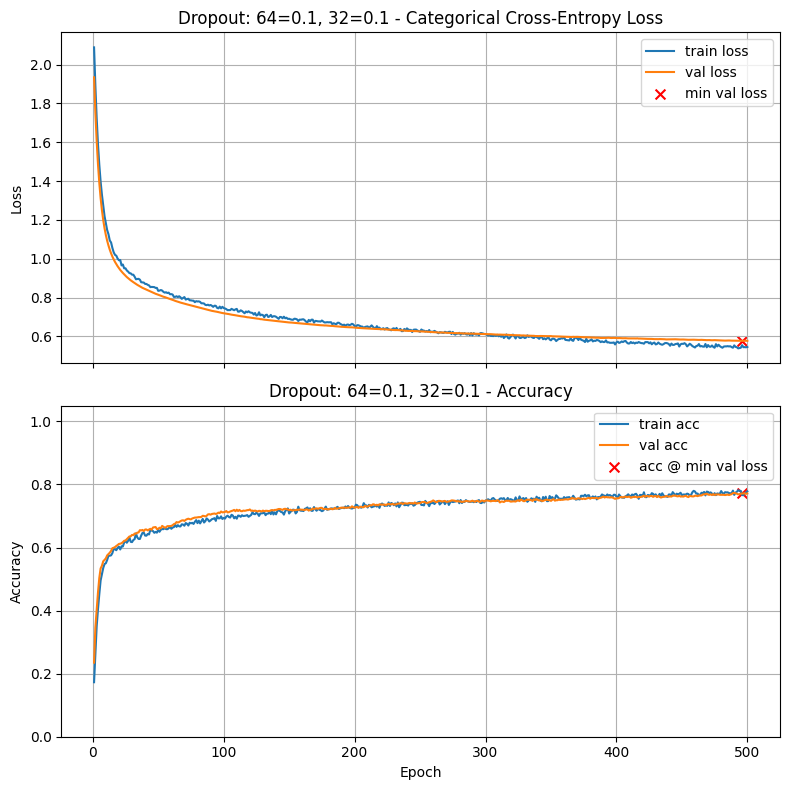

Final Training Loss:            0.5457
Final Training Accuracy:        0.7781
Final Validation Loss:          0.5778
Final Validation Accuracy:      0.7714
Minimum Validation Loss:        0.5774 (Epoch 496)
Validation Accuracy @ Min Loss: 0.7714

Test Loss: 0.6010
Test Accuracy: 0.7436

Validation-Test Gap (accuracy): 0.027143

Execution Time: 00:01:04

Dropout: 64=0.1, 32=0.2



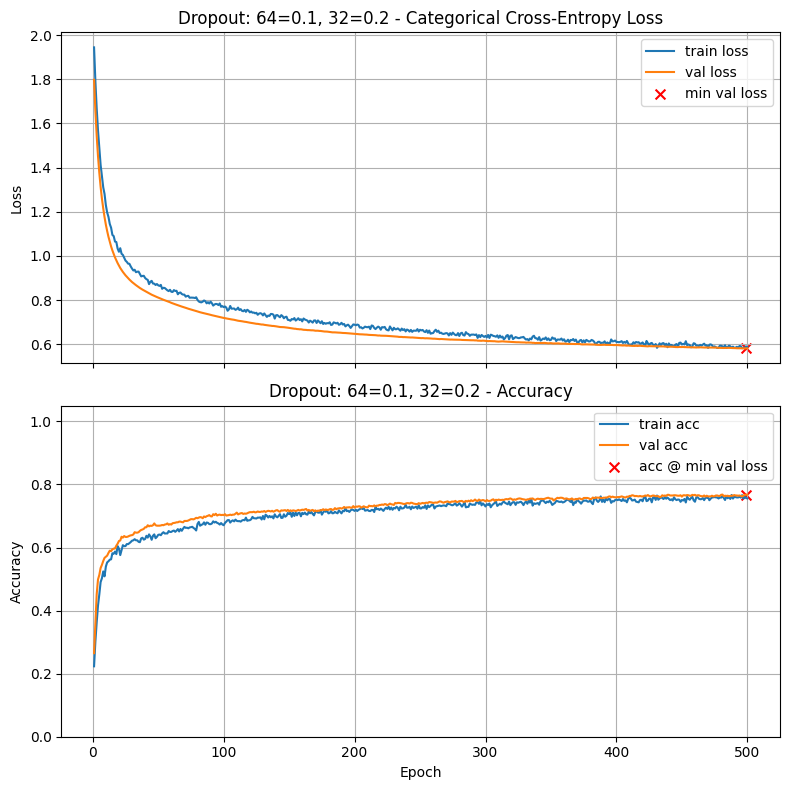

Final Training Loss:            0.5875
Final Training Accuracy:        0.7557
Final Validation Loss:          0.5817
Final Validation Accuracy:      0.7679
Minimum Validation Loss:        0.5816 (Epoch 499)
Validation Accuracy @ Min Loss: 0.7671

Test Loss: 0.6019
Test Accuracy: 0.7536

Validation-Test Gap (accuracy): 0.013571

Execution Time: 00:01:04

Dropout: 64=0.1, 32=0.3



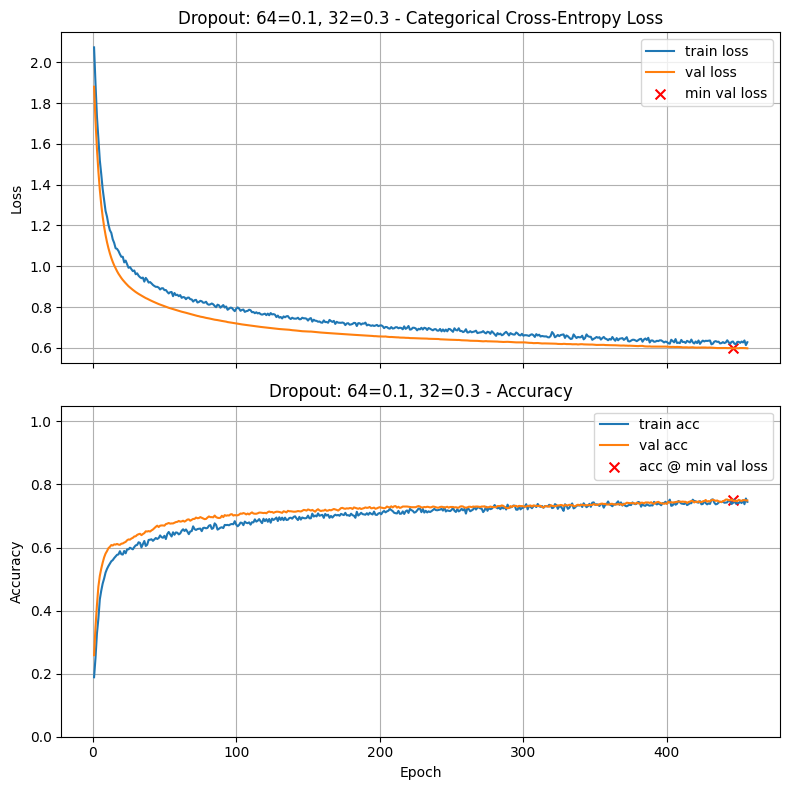

Final Training Loss:            0.6278
Final Training Accuracy:        0.7448
Final Validation Loss:          0.5979
Final Validation Accuracy:      0.7493
Minimum Validation Loss:        0.5975 (Epoch 446)
Validation Accuracy @ Min Loss: 0.7493

Test Loss: 0.6346
Test Accuracy: 0.7307

Validation-Test Gap (accuracy): 0.018571

Execution Time: 00:00:58

Dropout: 64=0.1, 32=0.4



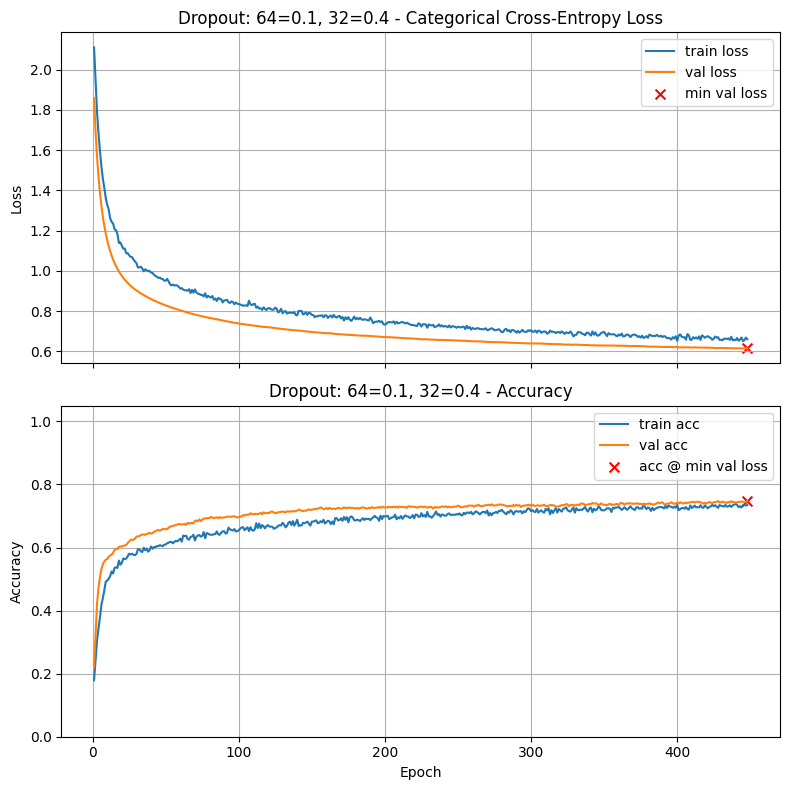

Final Training Loss:            0.6614
Final Training Accuracy:        0.7345
Final Validation Loss:          0.6153
Final Validation Accuracy:      0.7471
Minimum Validation Loss:        0.6153 (Epoch 448)
Validation Accuracy @ Min Loss: 0.7471

Test Loss: 0.6475
Test Accuracy: 0.7264

Validation-Test Gap (accuracy): 0.017143

Execution Time: 00:00:54

Dropout: 64=0.1, 32=0.5



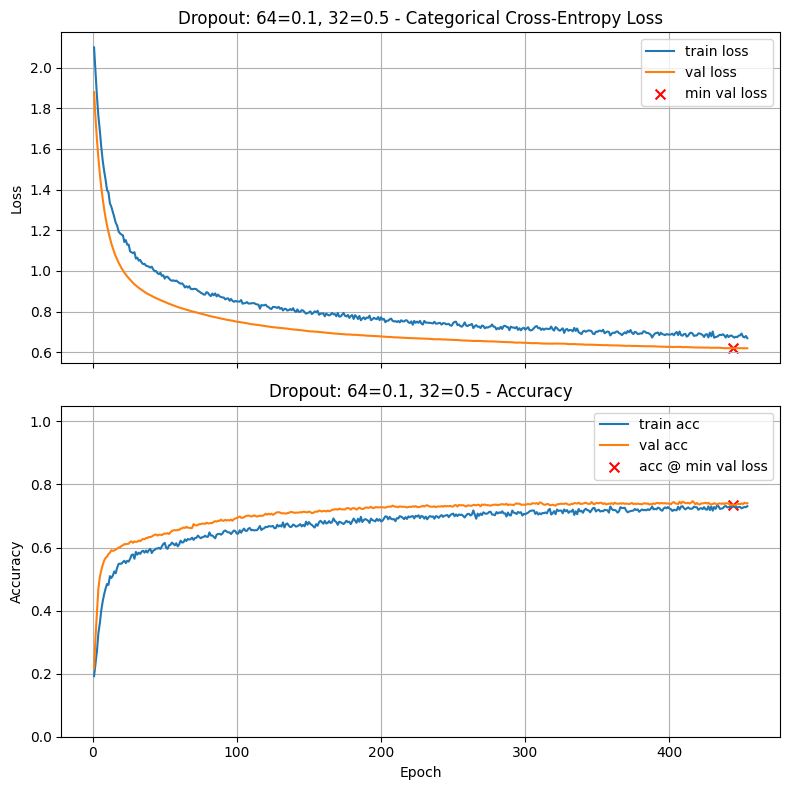

Final Training Loss:            0.6690
Final Training Accuracy:        0.7312
Final Validation Loss:          0.6194
Final Validation Accuracy:      0.7407
Minimum Validation Loss:        0.6189 (Epoch 444)
Validation Accuracy @ Min Loss: 0.7364

Test Loss: 0.6498
Test Accuracy: 0.7329

Validation-Test Gap (accuracy): 0.003571

Execution Time: 00:00:54

Dropout: 64=0.2, 32=0.0



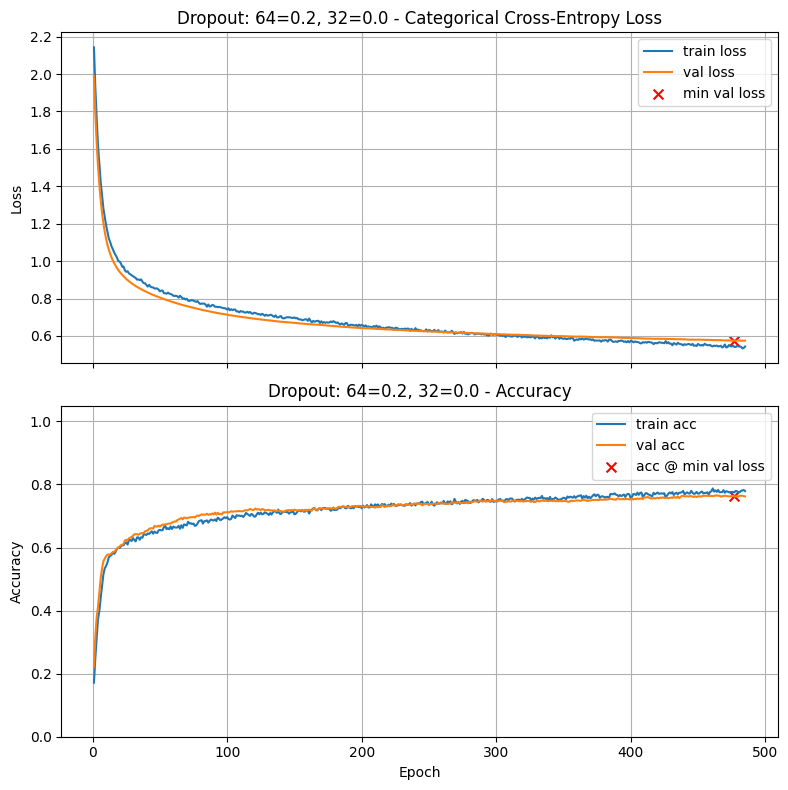

Final Training Loss:            0.5432
Final Training Accuracy:        0.7790
Final Validation Loss:          0.5749
Final Validation Accuracy:      0.7621
Minimum Validation Loss:        0.5744 (Epoch 477)
Validation Accuracy @ Min Loss: 0.7621

Test Loss: 0.5989
Test Accuracy: 0.7514

Validation-Test Gap (accuracy): 0.012143

Execution Time: 00:00:56

Dropout: 64=0.2, 32=0.1



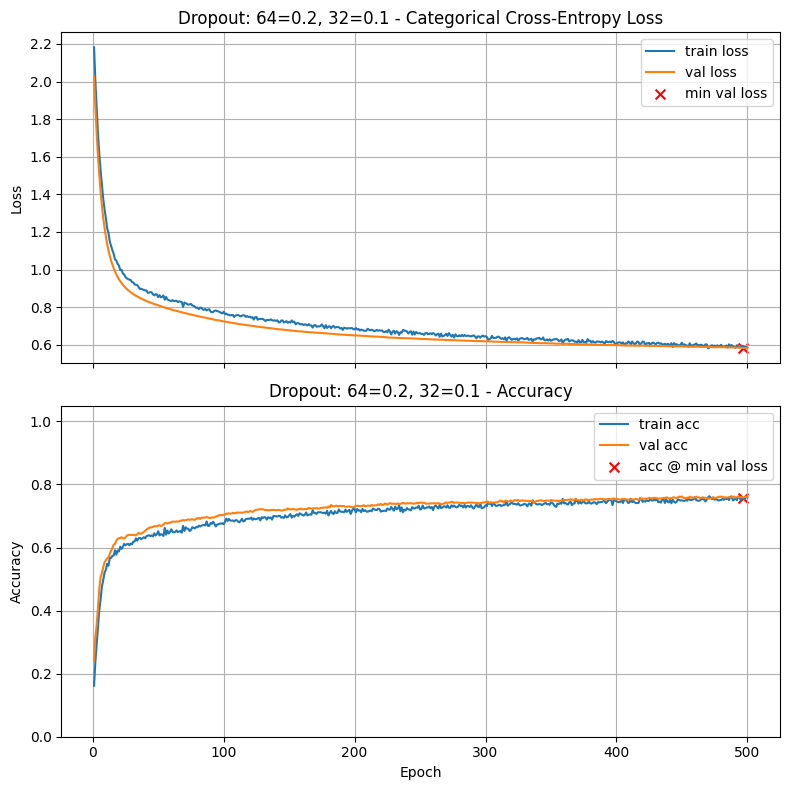

Final Training Loss:            0.5858
Final Training Accuracy:        0.7581
Final Validation Loss:          0.5837
Final Validation Accuracy:      0.7600
Minimum Validation Loss:        0.5833 (Epoch 497)
Validation Accuracy @ Min Loss: 0.7579

Test Loss: 0.6137
Test Accuracy: 0.7429

Validation-Test Gap (accuracy): 0.015000

Execution Time: 00:01:00

Dropout: 64=0.2, 32=0.2



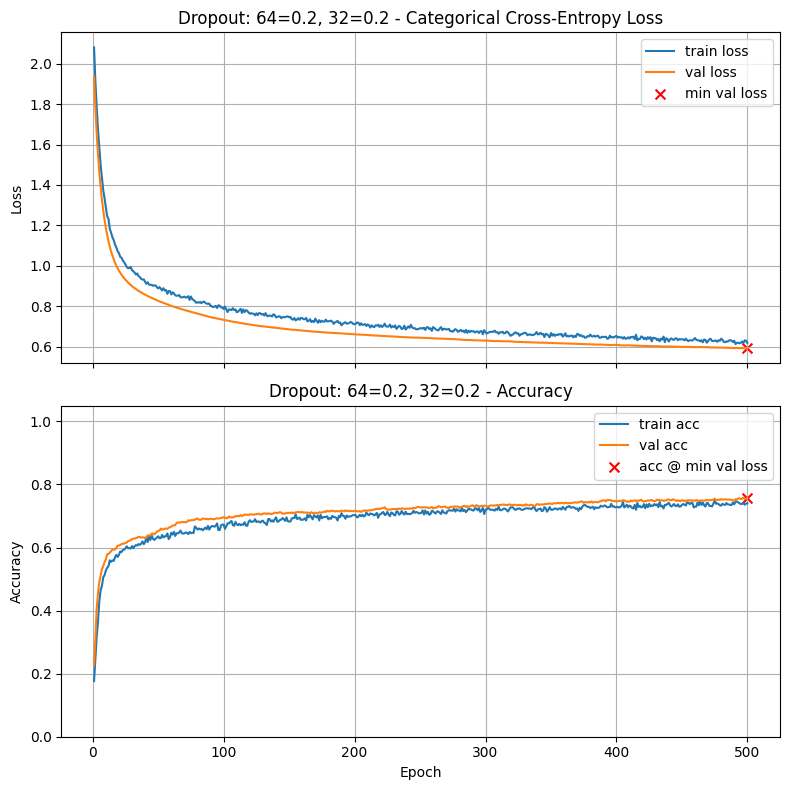

Final Training Loss:            0.6203
Final Training Accuracy:        0.7402
Final Validation Loss:          0.5930
Final Validation Accuracy:      0.7579
Minimum Validation Loss:        0.5930 (Epoch 500)
Validation Accuracy @ Min Loss: 0.7579

Test Loss: 0.6288
Test Accuracy: 0.7343

Validation-Test Gap (accuracy): 0.023571

Execution Time: 00:01:00

Dropout: 64=0.2, 32=0.3



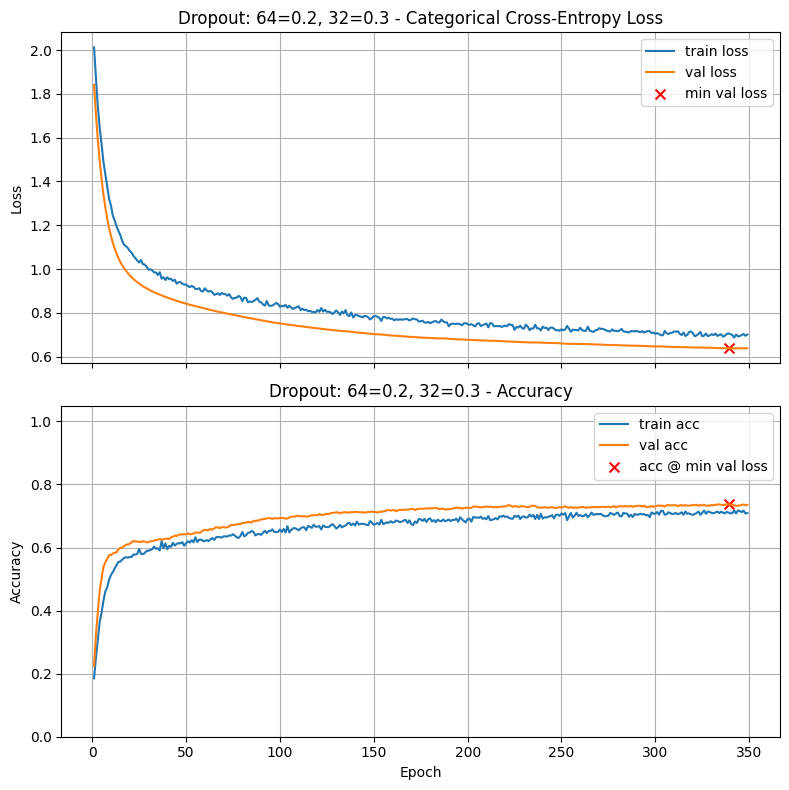

Final Training Loss:            0.7004
Final Training Accuracy:        0.7090
Final Validation Loss:          0.6376
Final Validation Accuracy:      0.7350
Minimum Validation Loss:        0.6373 (Epoch 339)
Validation Accuracy @ Min Loss: 0.7371

Test Loss: 0.6657
Test Accuracy: 0.7186

Validation-Test Gap (accuracy): 0.018571

Execution Time: 00:00:42

Dropout: 64=0.2, 32=0.4



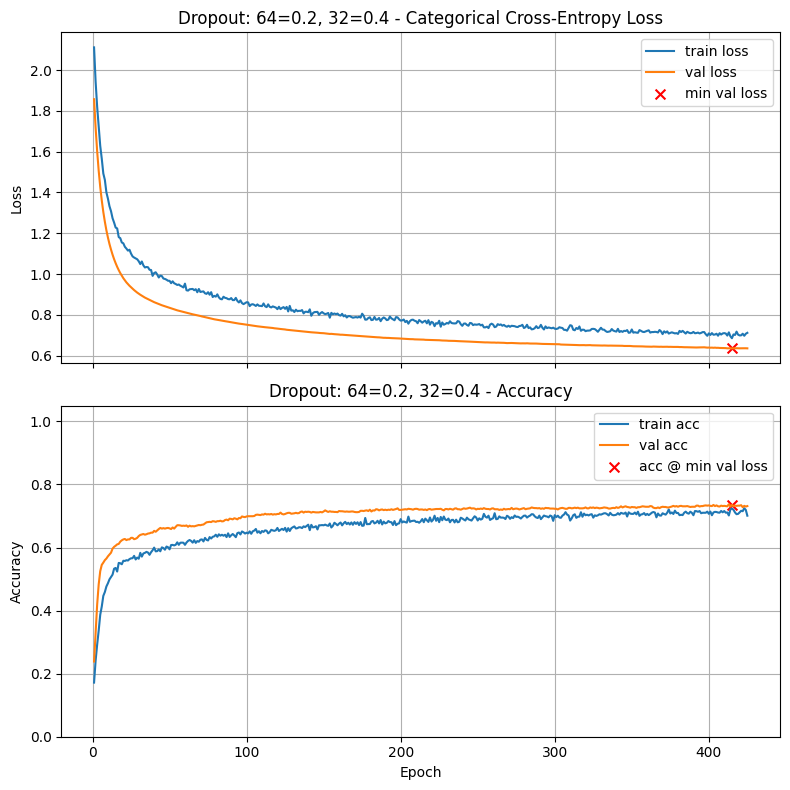

Final Training Loss:            0.7120
Final Training Accuracy:        0.7010
Final Validation Loss:          0.6360
Final Validation Accuracy:      0.7314
Minimum Validation Loss:        0.6358 (Epoch 415)
Validation Accuracy @ Min Loss: 0.7350

Test Loss: 0.6646
Test Accuracy: 0.7250

Validation-Test Gap (accuracy): 0.010000

Execution Time: 00:00:50

Dropout: 64=0.2, 32=0.5



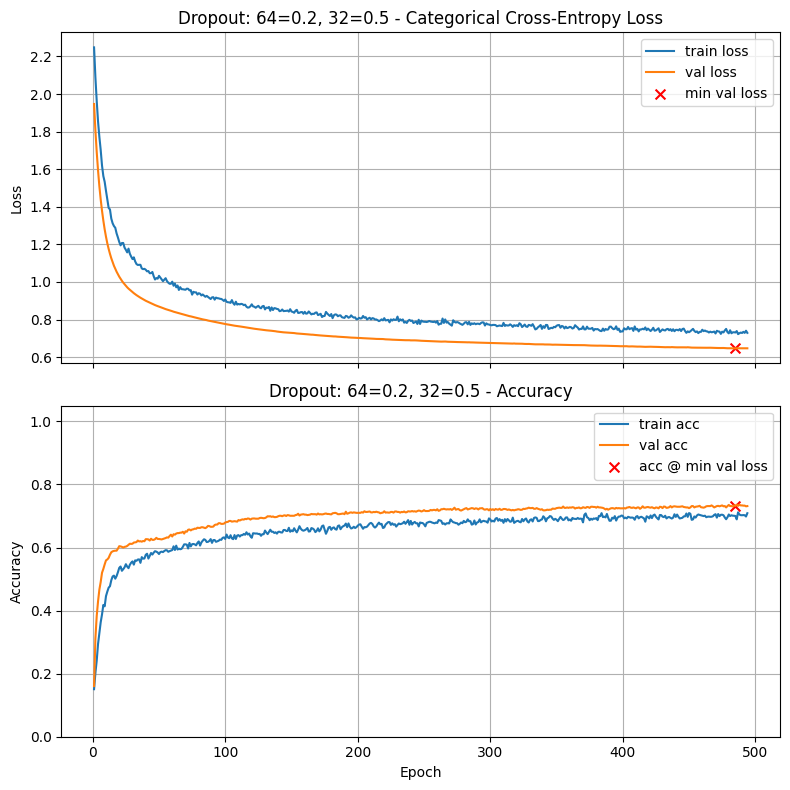

Final Training Loss:            0.7293
Final Training Accuracy:        0.7088
Final Validation Loss:          0.6472
Final Validation Accuracy:      0.7314
Minimum Validation Loss:        0.6468 (Epoch 485)
Validation Accuracy @ Min Loss: 0.7321

Test Loss: 0.6812
Test Accuracy: 0.7207

Validation-Test Gap (accuracy): 0.012857

Execution Time: 00:00:58
Dropout: 64=0.1, 32=0.1                 	0.7714
Dropout: 64=0.0, 32=0.1                 	0.7700
Dropout: 64=0.0, 32=0.3                 	0.7679
Dropout: 64=0.1, 32=0.2                 	0.7671
Dropout: 64=0.0, 32=0.0                 	0.7657
Dropout: 64=0.1, 32=0.0                 	0.7657
Dropout: 64=0.0, 32=0.2                 	0.7629
Dropout: 64=0.2, 32=0.0                 	0.7621
Dropout: 64=0.0, 32=0.5                 	0.7600
Dropout: 64=0.2, 32=0.1                 	0.7579
Dropout: 64=0.2, 32=0.2                 	0.7579
Dropout: 64=0.0, 32=0.4                 	0.7564
Dropout: 64=0.1, 32=0.3                 	0.7493
Dropout: 64=0.1, 32=0

In [44]:
# Your code here. Add as many cells as you need. 

results = {}
best_act = 'tanh'
best_lr = 1e-4

drop_64 = [0.0, 0.1, 0.2]
drop_32 = [0.0, 0.1, 0.2, 0.3, 0.4, 0.5]

for d64 in drop_64:
    for d32 in drop_32:
        model_baseline = build_model(X_train.shape[1], [(64, best_act, 0.0, d64), (32, best_act, 0.0, d32)], n_classes)
        train_and_test(model_baseline, title=f"Dropout: 64={d64}, 32={d32}", epochs = 500, lr_schedule=best_lr, verbose=0)

print_results()

In [45]:
# Set a3a to the pair (dropout_rate_64,dropout_rate_32) of dropout rates for the two hidden layers which provided the best 
# validation accuracy at the epoch of minimum validation loss

a3a = (0.1,0.1)             # Replace (0.0,0.0) with your answer

In [46]:
# Graded Answer
# DO NOT change this cell in any way          

print(f'a3a = {a3a}') 

a3a = (0.1, 0.1)


In [47]:
# Set a3b to the validation accuracy found by this best pair of dropout rates

a3b = 0.7714             # Replace 0.0 with your answer

In [48]:
# Graded Answer
# DO NOT change this cell in any way          

print(f'a3b = {a3b:.4f}') 

a3b = 0.7714


### Problem Four: L2 Regularization

In this problem, you will explore how **L2 regularization** (also called *weight decay*) can help prevent overfitting in neural networks. There are no absolute rules, but some useful heuristics are:

* Start simple by using the **same λ in both hidden layers**, with values:

  ```
      1e-4, 1e-3, 1e-2
  ```

* If validation results suggest underfitting in the first layer or persistent overfitting in the later one, then try adjusting per layer, for example:

  * First hidden layer: λ = 1e-4
  * Second hidden layer: λ = 1e-3

**Steps to follow:**

* Build and train the **baseline model** using the **activation function from Problem One** and the **learning rate from Problem Two**, but **without dropout**.
* Investigate at least the four cases suggested (three with the same λ and one with different λ values). You may also consider additional combinations.
* Identify which configuration produces the **best validation accuracy** at the epoch of **minimum validation loss**.
* Answer the graded questions.



L2 Regularization: 64=0.0001, 32=0.0001



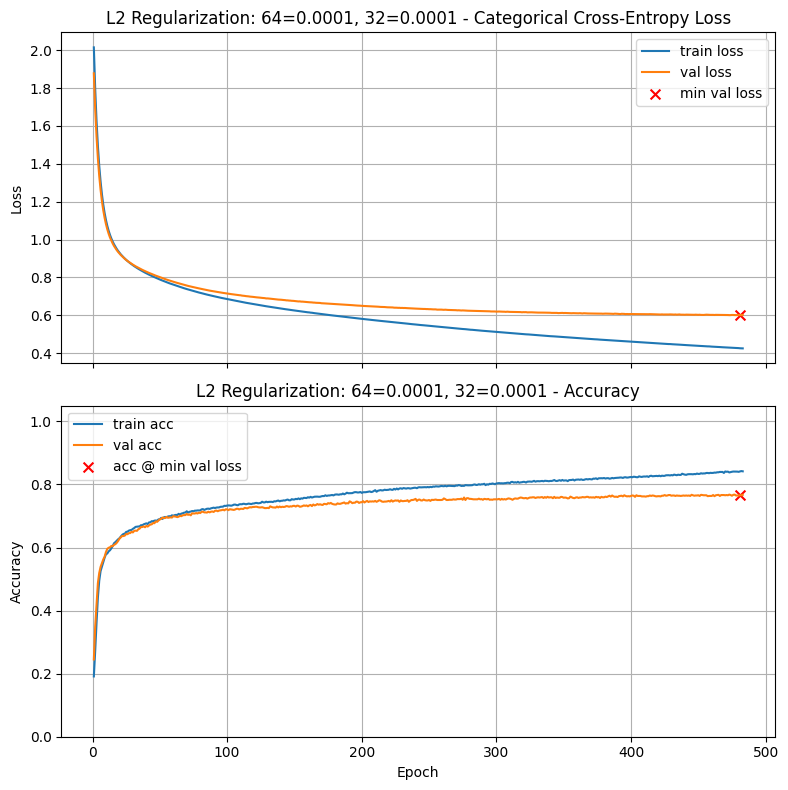

Final Training Loss:            0.4255
Final Training Accuracy:        0.8417
Final Validation Loss:          0.6018
Final Validation Accuracy:      0.7671
Minimum Validation Loss:        0.6011 (Epoch 481)
Validation Accuracy @ Min Loss: 0.7657

Test Loss: 0.5918
Test Accuracy: 0.7621

Validation-Test Gap (accuracy): 0.005714

Execution Time: 00:00:55

L2 Regularization: 64=0.001, 32=0.001



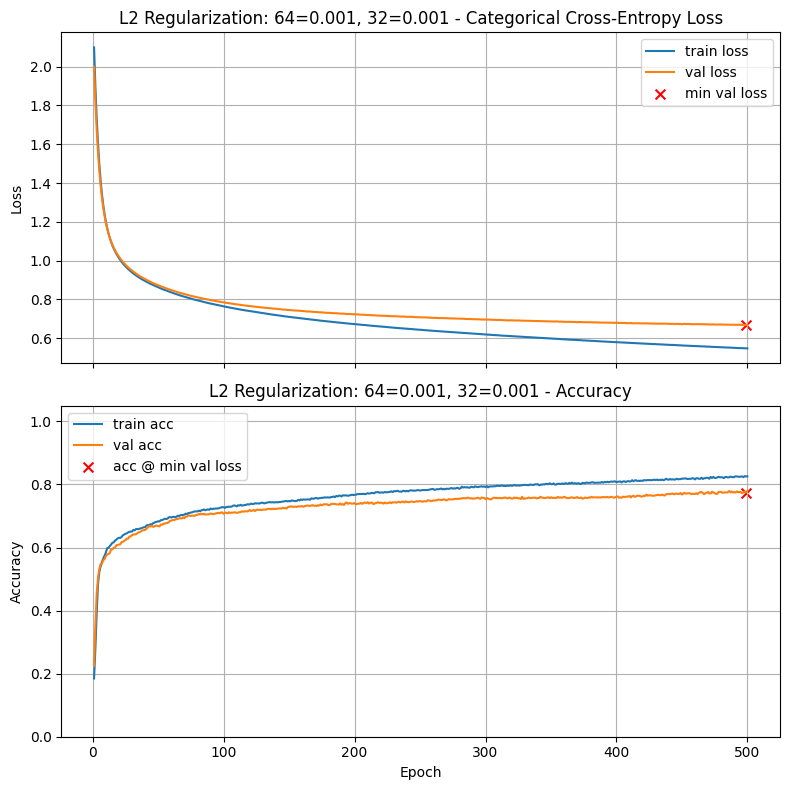

Final Training Loss:            0.5468
Final Training Accuracy:        0.8257
Final Validation Loss:          0.6679
Final Validation Accuracy:      0.7793
Minimum Validation Loss:        0.6677 (Epoch 499)
Validation Accuracy @ Min Loss: 0.7743

Test Loss: 0.6804
Test Accuracy: 0.7593

Validation-Test Gap (accuracy): 0.015000

Execution Time: 00:00:57

L2 Regularization: 64=0.01, 32=0.01



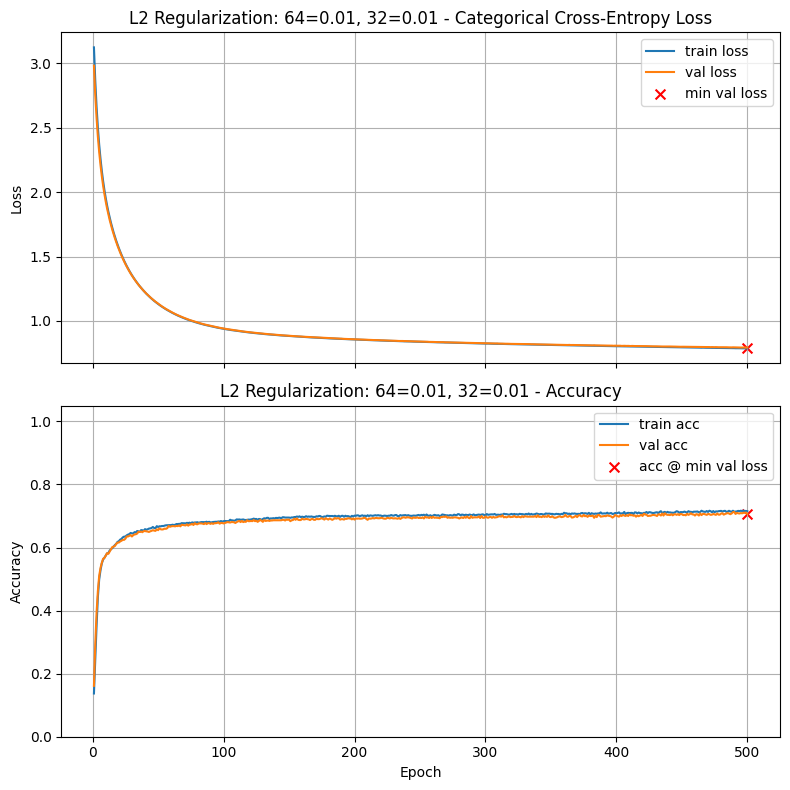

Final Training Loss:            0.7867
Final Training Accuracy:        0.7152
Final Validation Loss:          0.7928
Final Validation Accuracy:      0.7064
Minimum Validation Loss:        0.7928 (Epoch 500)
Validation Accuracy @ Min Loss: 0.7064

Test Loss: 0.8120
Test Accuracy: 0.7107

Validation-Test Gap (accuracy): 0.004286

Execution Time: 00:00:57

L2 Regularization: 64=0.0001, 32=0.001



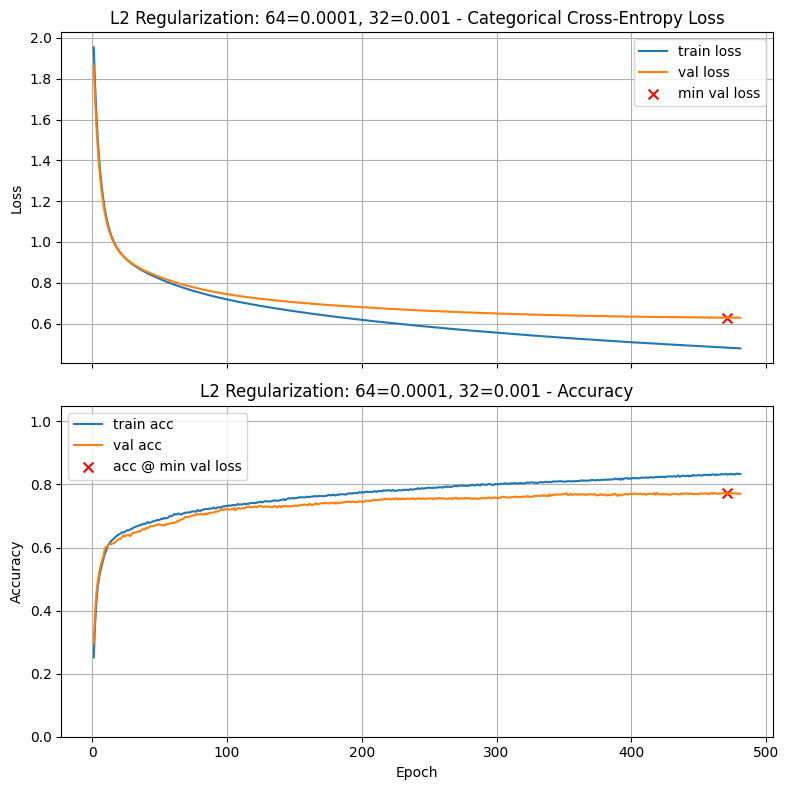

Final Training Loss:            0.4786
Final Training Accuracy:        0.8329
Final Validation Loss:          0.6282
Final Validation Accuracy:      0.7707
Minimum Validation Loss:        0.6280 (Epoch 471)
Validation Accuracy @ Min Loss: 0.7714

Test Loss: 0.6278
Test Accuracy: 0.7607

Validation-Test Gap (accuracy): 0.010714

Execution Time: 00:00:55
L2 Regularization: 64=0.001, 32=0.001   	0.7743
L2 Regularization: 64=0.0001, 32=0.001  	0.7714
L2 Regularization: 64=0.0001, 32=0.0001 	0.7657
L2 Regularization: 64=0.01, 32=0.01     	0.7064


In [49]:
# Your code here. Add as many cells as you need. 

results = {}
best_act = 'tanh'
best_lr = 1e-4

# No dropout
l2_layers = [(1e-4, 1e-4), (1e-3, 1e-3), (1e-2, 1e-2), (1e-4, 1e-3)]

for (l2_64, l2_32) in l2_layers:
    model_baseline = build_model(X_train.shape[1], [(64, best_act, l2_64, 0.0), (32, best_act, l2_32, 0.0)], n_classes)
    train_and_test(model_baseline, title=f"L2 Regularization: 64={l2_64}, 32={l2_32}", epochs = 500, lr_schedule=best_lr, verbose=0)

print_results()


In [50]:
# Set a4a to the pair (L2_lambda_64,L2_lambda_32) of the L2 lambdas for the two hidden layers which provided the best 
# validation accuracy at the epoch of minimum validation loss

a4a = (0.001,0.001)             # Replace (0.0,0.0) with your answer

In [51]:
# Graded Answer
# DO NOT change this cell in any way          

print(f'a4a = {a4a}') 

a4a = (0.001, 0.001)


In [52]:
# Set a4b to the validation accuracy found by this best pair of lambdas

a4b = 0.7743             # Replace 0.0 with your answer

In [53]:
# Graded Answer
# DO NOT change this cell in any way          

print(f'a4b = {a4b:.4f}') 

a4b = 0.7743


### Problem Five: Combining Dropout with L2 Regularization

In this problem, you will explore how **dropout** and **L2 regularization** can work together to prevent overfitting. These two methods complement each other, but must be balanced carefully. A useful rule of thumb is:

* If dropout is **high**, use a **smaller λ**.
* If dropout is **low**, you can afford a **larger λ**.

**Steps to follow:**

* Build and train the **baseline model** using the **activation function from Problem One** and the **learning rate from Problem Two**.
* Investigate combinations of dropout and L2:

  * First, use the **dropout rate you identified in Problem Three** as a baseline.
  * Then, add L2 to both hidden layers with values:

    ```
        1e-4, 1e-3, 1e-2
    ```

    while keeping dropout fixed.
  * Finally, try **reducing dropout slightly** when L2 is added to see if performance improves.
  * [Optional] You may wish to investigate other combinations not covered here; for example, promising but not optimal choices of dropout rates may provide overall better performance when combines with L2 Regulari 
* Identify which combination produces the **best validation accuracy** at the epoch of **minimum validation loss**.
* Answer the graded questions.




P5 drop w/ L2 Regularization: 64=0.1, 32=0.1, L2=0



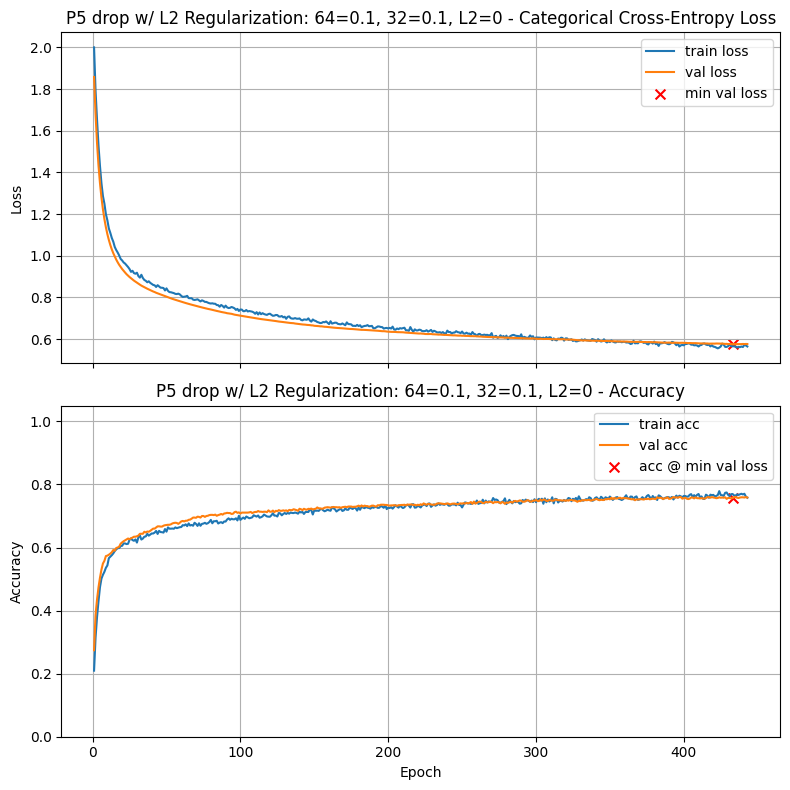

Final Training Loss:            0.5649
Final Training Accuracy:        0.7579
Final Validation Loss:          0.5767
Final Validation Accuracy:      0.7586
Minimum Validation Loss:        0.5757 (Epoch 433)
Validation Accuracy @ Min Loss: 0.7571

Test Loss: 0.6028
Test Accuracy: 0.7493

Validation-Test Gap (accuracy): 0.007857

Execution Time: 00:00:53

P5 Fixed drop w/ L2 Regularization: 64=0.0001, 32=0.0001, L2=0.0001



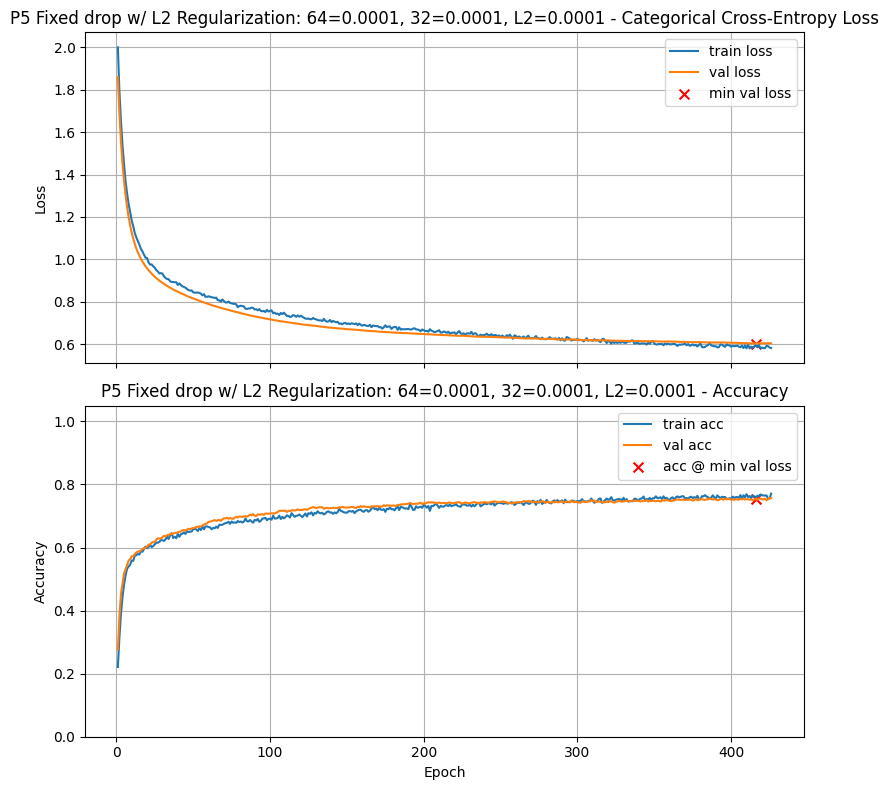

Final Training Loss:            0.5808
Final Training Accuracy:        0.7710
Final Validation Loss:          0.6031
Final Validation Accuracy:      0.7564
Minimum Validation Loss:        0.6024 (Epoch 416)
Validation Accuracy @ Min Loss: 0.7543

Test Loss: 0.6253
Test Accuracy: 0.7529

Validation-Test Gap (accuracy): 0.001429

Execution Time: 00:00:51

P5 Fixed drop w/ L2 Regularization: 64=0.001, 32=0.001, L2=0.001



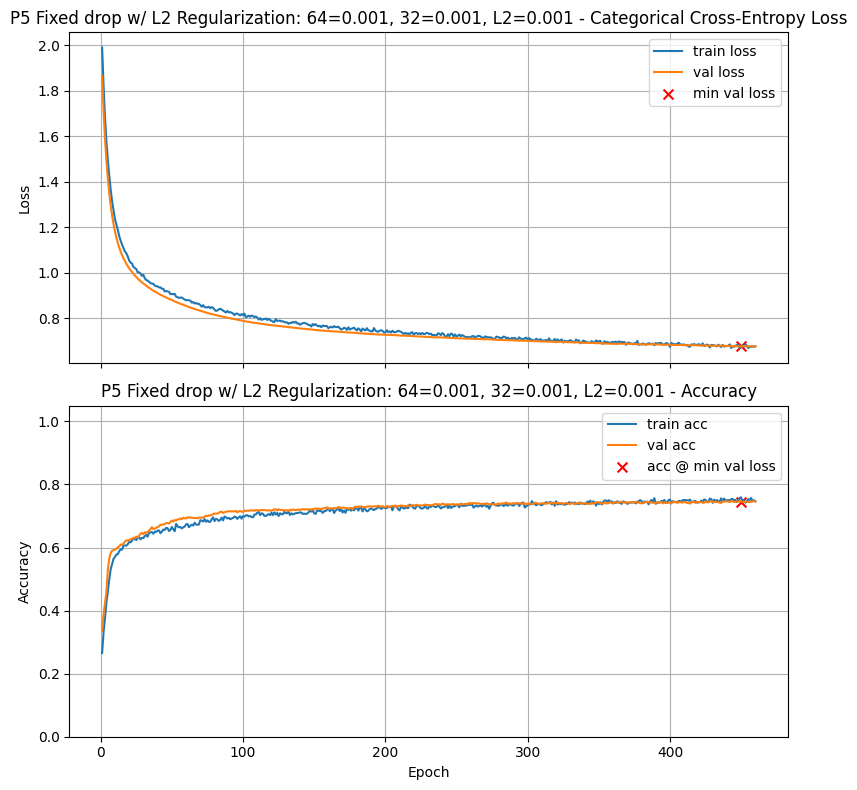

Final Training Loss:            0.6781
Final Training Accuracy:        0.7464
Final Validation Loss:          0.6778
Final Validation Accuracy:      0.7464
Minimum Validation Loss:        0.6773 (Epoch 450)
Validation Accuracy @ Min Loss: 0.7457

Test Loss: 0.6993
Test Accuracy: 0.7243

Validation-Test Gap (accuracy): 0.021429

Execution Time: 00:00:55

P5 Fixed drop w/ L2 Regularization: 64=0.01, 32=0.01, L2=0.01



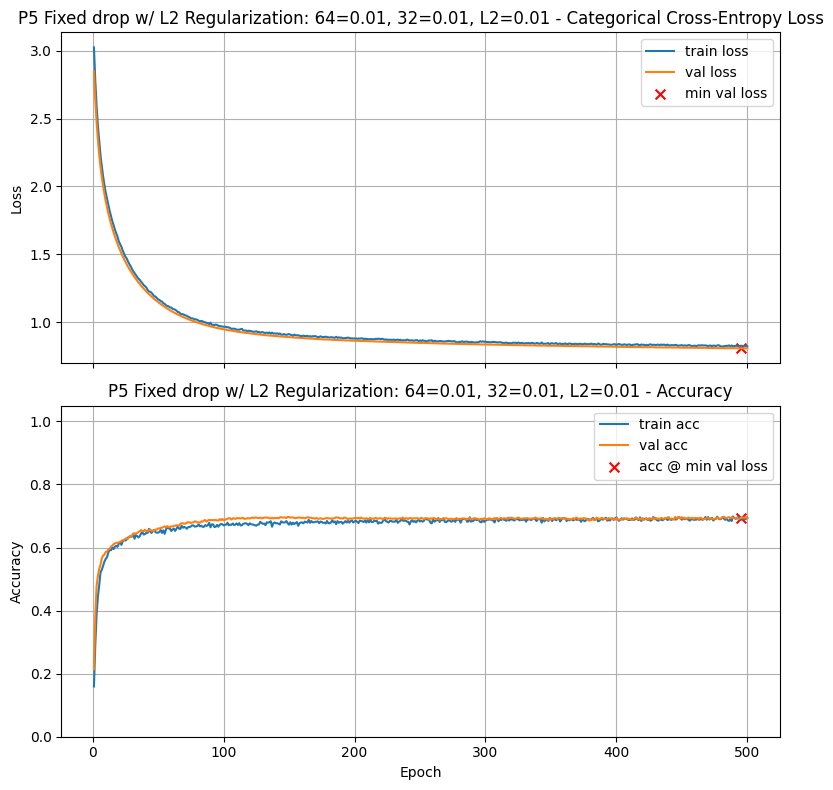

Final Training Loss:            0.8211
Final Training Accuracy:        0.6940
Final Validation Loss:          0.8063
Final Validation Accuracy:      0.6929
Minimum Validation Loss:        0.8063 (Epoch 495)
Validation Accuracy @ Min Loss: 0.6936

Test Loss: 0.8256
Test Accuracy: 0.7000

Validation-Test Gap (accuracy): 0.006429

Execution Time: 00:01:00

P5 L2 w/ Reduced Dropout: d64=0.0, d32=0.1, L2=0.001



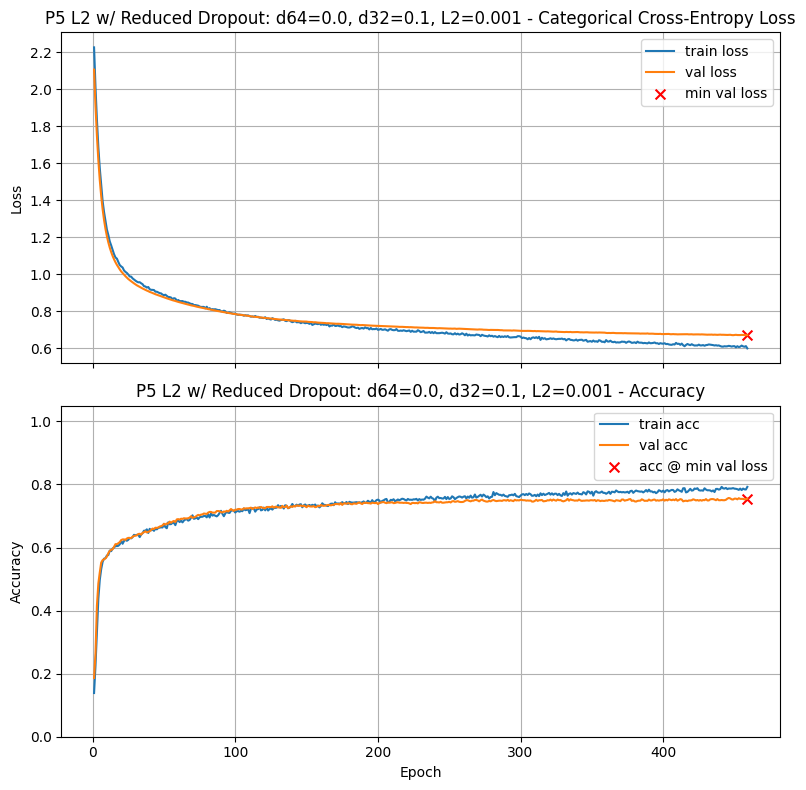

Final Training Loss:            0.6004
Final Training Accuracy:        0.7924
Final Validation Loss:          0.6718
Final Validation Accuracy:      0.7550
Minimum Validation Loss:        0.6718 (Epoch 459)
Validation Accuracy @ Min Loss: 0.7550

Test Loss: 0.6915
Test Accuracy: 0.7379

Validation-Test Gap (accuracy): 0.014286

Execution Time: 00:00:54

P5 L2 w/ Reduced Dropout: d64=0.1, d32=0.0, L2=0.001



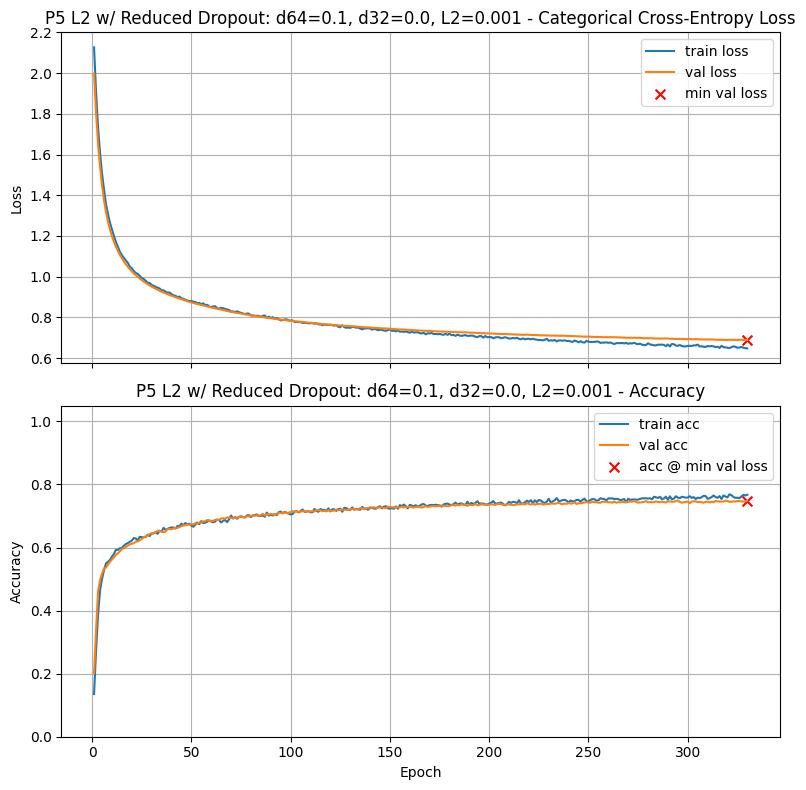

Final Training Loss:            0.6476
Final Training Accuracy:        0.7674
Final Validation Loss:          0.6888
Final Validation Accuracy:      0.7486
Minimum Validation Loss:        0.6888 (Epoch 330)
Validation Accuracy @ Min Loss: 0.7486

Test Loss: 0.7069
Test Accuracy: 0.7393

Validation-Test Gap (accuracy): 0.008571

Execution Time: 00:00:39

P5 L2 w/ Reduced Dropout: d64=0.0, d32=0.0, L2=0.001



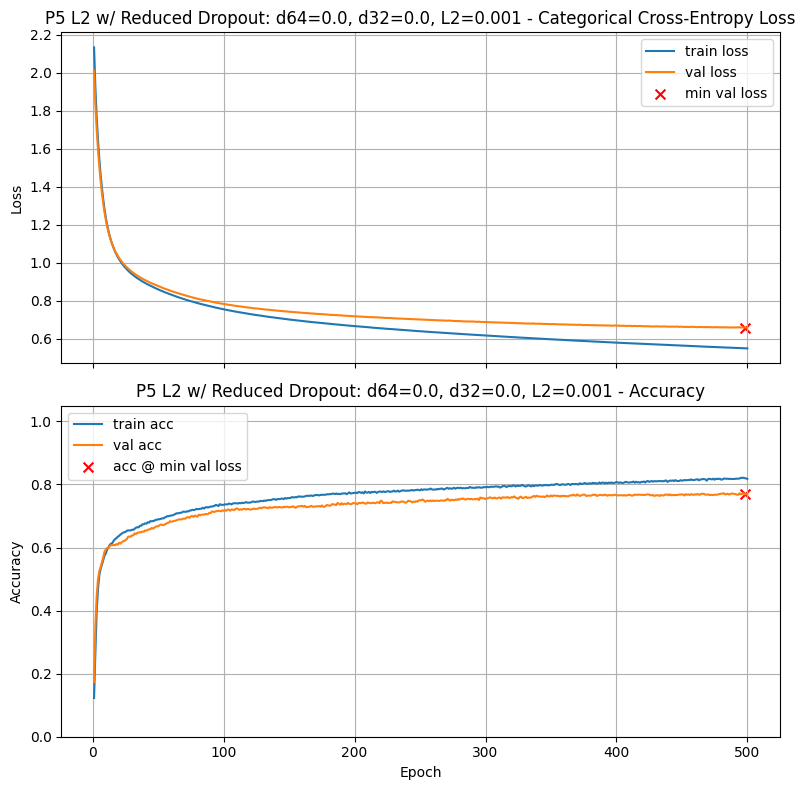

Final Training Loss:            0.5482
Final Training Accuracy:        0.8176
Final Validation Loss:          0.6587
Final Validation Accuracy:      0.7686
Minimum Validation Loss:        0.6576 (Epoch 498)
Validation Accuracy @ Min Loss: 0.7686

Test Loss: 0.6795
Test Accuracy: 0.7614

Validation-Test Gap (accuracy): 0.007143

Execution Time: 00:00:58
P5 L2 w/ Reduced Dropout: d64=0.0, d32=0.0, L2=0.001	0.7686
P5 drop w/ L2 Regularization: 64=0.1, 32=0.1, L2=0	0.7571
P5 L2 w/ Reduced Dropout: d64=0.0, d32=0.1, L2=0.001	0.7550
P5 Fixed drop w/ L2 Regularization: 64=0.0001, 32=0.0001, L2=0.0001	0.7543
P5 L2 w/ Reduced Dropout: d64=0.1, d32=0.0, L2=0.001	0.7486
P5 Fixed drop w/ L2 Regularization: 64=0.001, 32=0.001, L2=0.001	0.7457
P5 Fixed drop w/ L2 Regularization: 64=0.01, 32=0.01, L2=0.01	0.6936


In [54]:
# Your code here. Add as many cells as you need.

results = {}
best_act = 'tanh'
best_lr = 1e-4
best_drop_64, best_drop_32 = (0.1, 0.1)

l2_values = [1e-4, 1e-3, 1e-2]
model_baseline = build_model(X_train.shape[1], [(64, best_act, 0.0, best_drop_64), (32, best_act, 0.0, best_drop_32)], n_classes)
train_and_test(model_baseline, title=f"P5 drop w/ L2 Regularization: 64={best_drop_64}, 32={best_drop_32}, L2=0", epochs = 500, lr_schedule=best_lr, verbose=0)

for lam in l2_values:
    model_baseline = build_model(X_train.shape[1], [(64, best_act, lam, best_drop_64), (32, best_act, lam, best_drop_32)], n_classes)
    train_and_test(model_baseline, title=f"P5 Fixed drop w/ L2 Regularization: 64={lam}, 32={lam}, L2={lam}", epochs = 500, lr_schedule=best_lr, verbose=0)

reduce_dropout = [(0.0, 0.1), (0.1, 0.0), (0.0, 0.0)]

best_l2 = 1e-3

for (d64, d32) in reduce_dropout:
    model_baseline = build_model(X_train.shape[1], [(64, best_act, best_l2, d64), (32, best_act, best_l2, d32)], n_classes)
    train_and_test(model_baseline, title=f"P5 L2 w/ Reduced Dropout: d64={d64}, d32={d32}, L2={best_l2}", epochs = 500, lr_schedule=best_lr, verbose=0)

print_results()

In [55]:
# Set a5 to the validation accuracy found by this best combination of dropout and L2 regularization

a5 = 0.7686             # Replace 0.0 with your answer

In [56]:
# Graded Answer
# DO NOT change this cell in any way          

print(f'a5 = {a5:.4f}') 

a5 = 0.7686


### Problem Six: Build and Train Your Best Model

In this final problem, you will design and train your **best-performing model** using the techniques explored in the previous problems. You may make your own choices for:

* **Model architecture** (number of layers, widths, etc.)
* **Learning rate**
* **Batch size** (a new hyperparameter not varied in earlier problems)
* **Dropout rates** in both layers
* **L2 λ values** in both layers
* **[Optional but strongly suggested]:** Learning rate scheduling, using either **Exponential Decay** or **Cosine Decay**.

  * For Exponential Decay, typical decay rates are **0.90–0.999**, with **0.95** often a good starting point.

**Steps to follow:**

* Build and train the model according to your design choices.
* Use early stopping as before to evaluate performance at the epoch of **minimum validation loss**.
* Answer the graded question.



Best Model with LR Schedule and Exponential Decay



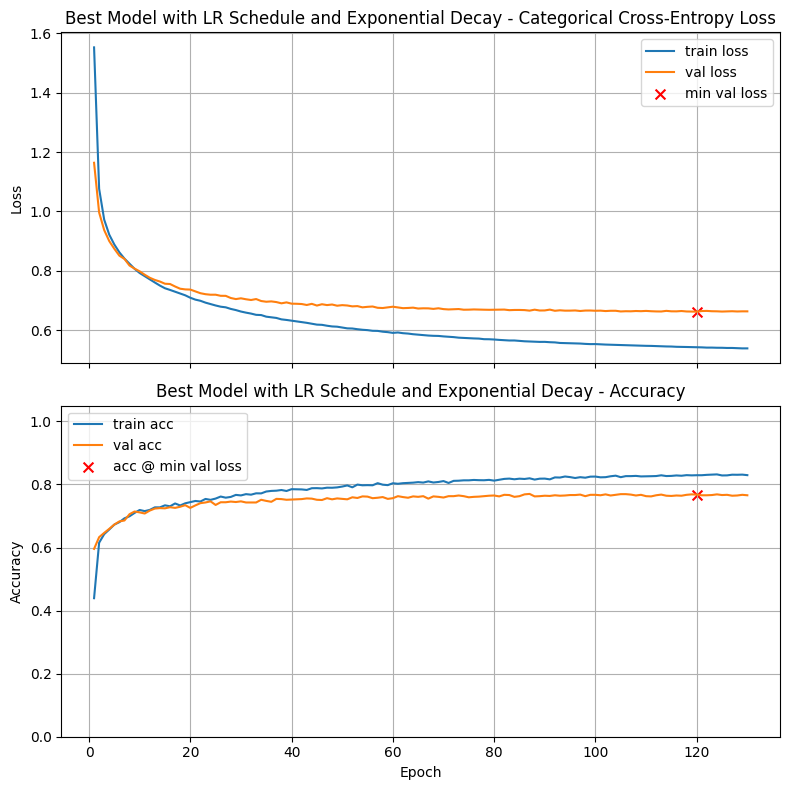

Final Training Loss:            0.5389
Final Training Accuracy:        0.8295
Final Validation Loss:          0.6636
Final Validation Accuracy:      0.7657
Minimum Validation Loss:        0.6625 (Epoch 120)
Validation Accuracy @ Min Loss: 0.7679

Test Loss: 0.6856
Test Accuracy: 0.7564

Validation-Test Gap (accuracy): 0.011429

Execution Time: 00:00:15
Best Model with LR Schedule and Exponential Decay	0.7679


In [57]:
# Your code here

lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(initial_learning_rate=1e-3, decay_steps=200, decay_rate=0.95, staircase=True)

results = {}
best_act = 'tanh'
best_l2 = 1e-3

best_model = build_model(X_train.shape[1], [(64, best_act, best_l2, 0.0), (32, best_act, best_l2, 0.0)], n_classes)
train_and_test(best_model, title=f"Best Model with LR Schedule and Exponential Decay", epochs = 500, lr_schedule=lr_schedule, batch_size=64, verbose=0)

print_results()

In [58]:
# Set a6 to the validation accuracy found by this best model

a6 = 0.7679             # Replace 0.0 with your answer

In [59]:
# Graded Answer
# DO NOT change this cell in any way          

print(f'a6 = {a6:.4f}') 

a6 = 0.7679


### Optional: Print out your results of all experiments

In [35]:
print_results()

Activation: tanh                        	0.7793
Activation: sigmoid                     	0.7736
Activation: relu                        	0.7529


## Reflection Questions (ungraded)

It would be a great idea to think through your answers to these questions, then give ChatGPT (or other AI tool) a PDF of your
homework, and **discuss** (not just ask) these. 

1. Activation Functions:

    - Why do you think one activation function worked better than the others for this task?
    
    - How might this choice differ for deeper or wider networks?

2. Learning Rate:

    - Would a much smaller learning rate (with many more epochs) likely produce better accuracy?
    
    - When is it worth training longer with a smaller step size, and when is it unnecessary?

3. Dropout vs. L2:

    - Which form of regularization — dropout or L2 — gave better results in your experiments?
    
    - Why might one method be more effective in this setting?

4. Combining Dropout and L2:

    - Why might the combination of dropout and L2 sometimes perform worse than using one method alone?
    
    - What does this tell you about the balance between bias and variance in regularization?

5. Best Model:

    - When you designed your best model, what trade-offs did you notice between model complexity, training stability, and generalization?
    
    - Did learning rate scheduling (if you tried it) improve results? Why might it help?